# NLP

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# 공통 모듈 임포트
import numpy as np
import pandas as pd

import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "NLP"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
import warnings
warnings.filterwarnings(action='ignore')

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False
    
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


No GPU was detected. CNNs can be very slow without a GPU.


## 양방향 LSTM을 이용한 품사 태깅

In [2]:
import nltk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

### 영어 코퍼스에 토큰화 와 품사 태깅 전처리를 진행한 문장 데이터 가져오기

In [3]:
tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences)) # 문장 샘플의 개수 출력

품사 태깅이 된 문장 개수:  3914


### 첫번째 샘플 출력

In [4]:
print(tagged_sentences[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


### 단어는 sentences에 태깅 정보는 pos_tags에 저장

In [5]:
sentences, pos_tags = [], [] 
for tagged_sentence in tagged_sentences: # 3,914개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장한다.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    pos_tags.append(list(tag_info)) # 각 샘플에서 품사 태깅 정보만 저장한다.
    
print(sentences[0])
print(pos_tags[0])    

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


In [6]:
print(sentences[8])
print(pos_tags[8])

['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


### 각 샘플의 길이 확인

샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


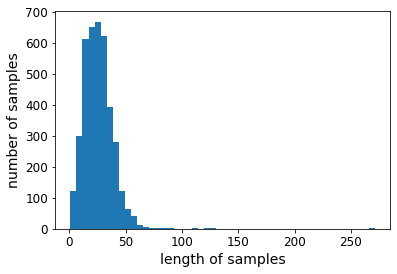

In [7]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 정수 인코딩

In [8]:
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [9]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


### 패딩

In [10]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.

### 훈련 데이터 와 테스트 데이터 분리

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150, 47)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150, 47)


### POS Tagger 모델 생성 및 훈련

In [13]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
# from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding

model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer= "adam", metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=6,  validation_data=(X_test, y_test))

2021-07-26 07:30:17.369679: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-26 07:30:18.740651: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6
25/25 [==============================] - 51s 1s/step - loss: 0.6236 - accuracy: 0.1159 - val_loss: 0.5067 - val_accuracy: 0.1602
Epoch 2/6
25/25 [==============================] - 28s 1s/step - loss: 0.4972 - accuracy: 0.1807 - val_loss: 0.4609 - val_accuracy: 0.3644
Epoch 3/6
25/25 [==============================] - 28s 1s/step - loss: 0.4451 - accuracy: 0.3875 - val_loss: 0.3300 - val_accuracy: 0.5018
Epoch 4/6
25/25 [==============================] - 28s 1s/step - loss: 0.2925 - accuracy: 0.5679 - val_loss: 0.1946 - val_accuracy: 0.7276
Epoch 5/6
25/25 [==============================] - 28s 1s/step - loss: 0.1631 - accuracy: 0.7808 - val_loss: 0.1067 - val_accuracy: 0.8593
Epoch 6/6
25/25 [==============================] - 27s 1s/step - loss: 0.0801 - accuracy: 0.9030 - val_loss: 0.0693 - val_accuracy: 0.8995


In [14]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 3s 99ms/step - loss: 0.0693 - accuracy: 0.8995

 테스트 정확도: 0.8995


### 실제값 과 예측값 확인

In [15]:
index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .


## Subword Tokenizer

### BPE 알고리즘

In [19]:
import re, collections
from IPython.display import display, Markdown, Latex

num_merges = 10

dictionary = {'l o w </w>' : 5,
         'l o w e r </w>' : 2,
         'n e w e s t </w>':6,
         'w i d e s t </w>':3
         }

def get_stats(dictionary):
    # 유니그램의 pair들의 빈도수를 카운트
    pairs = collections.defaultdict(int)
    for word, freq in dictionary.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    print('현재 pair들의 빈도수 :', dict(pairs))
    return pairs

def merge_dictionary(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

bpe_codes = {}
bpe_codes_reverse = {}

for i in range(num_merges):
    display(Markdown("### Iteration {}".format(i + 1)))
    pairs = get_stats(dictionary)
    best = max(pairs, key=pairs.get)
    dictionary = merge_dictionary(best, dictionary)

    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best

    print("new merge: {}".format(best))
    print("dictionary: {}".format(dictionary))

### Iteration 1

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 8, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('e', 's'): 9, ('s', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'e'): 3}
new merge: ('e', 's')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}


### Iteration 2

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'es'): 6, ('es', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'es'): 3}
new merge: ('es', 't')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}


### Iteration 3

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est'): 6, ('est', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est'): 3}
new merge: ('est', '</w>')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 4

현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('l', 'o')
dictionary: {'lo w </w>': 5, 'lo w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 5

현재 pair들의 빈도수 : {('lo', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('lo', 'w')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 6

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('n', 'e')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'ne w est</w>': 6, 'w i d est</w>': 3}


### Iteration 7

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('ne', 'w'): 6, ('w', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('ne', 'w')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'new est</w>': 6, 'w i d est</w>': 3}


### Iteration 8

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('new', 'est</w>'): 6, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('new', 'est</w>')
dictionary: {'low </w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 9

현재 pair들의 빈도수 : {('low', '</w>'): 5, ('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('low', '</w>')
dictionary: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 10

현재 pair들의 빈도수 : {('low', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est</w>'): 3}
new merge: ('w', 'i')
dictionary: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wi d est</w>': 3}


In [20]:
#merge 했던 기록 확인
print(bpe_codes)

{('e', 's'): 0, ('es', 't'): 1, ('est', '</w>'): 2, ('l', 'o'): 3, ('lo', 'w'): 4, ('n', 'e'): 5, ('ne', 'w'): 6, ('new', 'est</w>'): 7, ('low', '</w>'): 8, ('w', 'i'): 9}


### BPE 알고리즘을 이용한 OOV 대처

In [21]:
def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as a tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def encode(orig):
    """Encode word based on list of BPE merge operations, which are applied consecutively"""

    word = tuple(orig) + ('</w>',)
    display(Markdown("__word split into characters:__ <tt>{}</tt>".format(word)))

    pairs = get_pairs(word)    

    if not pairs:
        return orig

    iteration = 0
    while True:
        iteration += 1
        display(Markdown("__Iteration {}:__".format(iteration)))

        print("bigrams in the word: {}".format(pairs))
        bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
        print("candidate for merging: {}".format(bigram))
        if bigram not in bpe_codes:
            display(Markdown("__Candidate not in BPE merges, algorithm stops.__"))
            break
        first, second = bigram
        new_word = []
        i = 0
        while i < len(word):
            try:
                j = word.index(first, i)
                new_word.extend(word[i:j])
                i = j
            except:
                new_word.extend(word[i:])
                break

            if word[i] == first and i < len(word)-1 and word[i+1] == second:
                new_word.append(first+second)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_word = tuple(new_word)
        word = new_word
        print("word after merging: {}".format(word))
        if len(word) == 1:
            break
        else:
            pairs = get_pairs(word)

    # 특별 토큰인 </w>는 출력하지 않는다.
    if word[-1] == '</w>':
        word = word[:-1]
    elif word[-1].endswith('</w>'):
        word = word[:-1] + (word[-1].replace('</w>',''),)

    return word

In [22]:
encode("loki")

__word split into characters:__ <tt>('l', 'o', 'k', 'i', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('o', 'k'), ('k', 'i'), ('l', 'o'), ('i', '</w>')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'k', 'i', '</w>')


__Iteration 2:__

bigrams in the word: {('i', '</w>'), ('k', 'i'), ('lo', 'k')}
candidate for merging: ('i', '</w>')


__Candidate not in BPE merges, algorithm stops.__

('lo', 'k', 'i')

In [23]:
encode("lowest")

__word split into characters:__ <tt>('l', 'o', 'w', 'e', 's', 't', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('w', 'e'), ('l', 'o'), ('s', 't'), ('e', 's'), ('o', 'w'), ('t', '</w>')}
candidate for merging: ('e', 's')
word after merging: ('l', 'o', 'w', 'es', 't', '</w>')


__Iteration 2:__

bigrams in the word: {('w', 'es'), ('l', 'o'), ('es', 't'), ('o', 'w'), ('t', '</w>')}
candidate for merging: ('es', 't')
word after merging: ('l', 'o', 'w', 'est', '</w>')


__Iteration 3:__

bigrams in the word: {('o', 'w'), ('l', 'o'), ('est', '</w>'), ('w', 'est')}
candidate for merging: ('est', '</w>')
word after merging: ('l', 'o', 'w', 'est</w>')


__Iteration 4:__

bigrams in the word: {('o', 'w'), ('w', 'est</w>'), ('l', 'o')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'est</w>')


__Iteration 5:__

bigrams in the word: {('w', 'est</w>'), ('lo', 'w')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'est</w>')


__Iteration 6:__

bigrams in the word: {('low', 'est</w>')}
candidate for merging: ('low', 'est</w>')


__Candidate not in BPE merges, algorithm stops.__

('low', 'est')

In [24]:
encode("lowing")

__word split into characters:__ <tt>('l', 'o', 'w', 'i', 'n', 'g', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('n', 'g'), ('i', 'n'), ('l', 'o'), ('w', 'i'), ('g', '</w>'), ('o', 'w')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'i', 'n', 'g', '</w>')


__Iteration 2:__

bigrams in the word: {('n', 'g'), ('lo', 'w'), ('i', 'n'), ('w', 'i'), ('g', '</w>')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'i', 'n', 'g', '</w>')


__Iteration 3:__

bigrams in the word: {('n', 'g'), ('g', '</w>'), ('low', 'i'), ('i', 'n')}
candidate for merging: ('n', 'g')


__Candidate not in BPE merges, algorithm stops.__

('low', 'i', 'n', 'g')

In [25]:
encode("highing")

__word split into characters:__ <tt>('h', 'i', 'g', 'h', 'i', 'n', 'g', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('i', 'g'), ('n', 'g'), ('i', 'n'), ('g', 'h'), ('g', '</w>'), ('h', 'i')}
candidate for merging: ('i', 'g')


__Candidate not in BPE merges, algorithm stops.__

('h', 'i', 'g', 'h', 'i', 'n', 'g')

## IMDB 리뷰 토큰화하기

In [1]:
import sentencepiece as spm
import pandas as pd
import urllib.request
import csv

### 데이터 가져오기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="./data/IMDb_Reviews.csv")

train_df = pd.read_csv('./data/IMDb_Reviews.csv')
train_df['review']

0        My family and I normally do not watch local mo...
1        Believe it or not, this was at one time the wo...
2        After some internet surfing, I found the "Home...
3        One of the most unheralded great works of anim...
4        It was the Sixties, and anyone with long hair ...
                               ...                        
49995    the people who came up with this are SICK AND ...
49996    The script is so so laughable... this in turn,...
49997    "So there's this bride, you see, and she gets ...
49998    Your mind will not be satisfied by this nobud...
49999    The chaser's war on everything is a weekly sho...
Name: review, Length: 50000, dtype: object

In [3]:
print('리뷰 개수 :',len(train_df)) # 리뷰 개수 출력

리뷰 개수 : 50000


### DataFrame 을 파일에 저장

In [4]:
with open('./data/imdb_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_df['review']))

### 센텐스피스로 단어 집합과 각 단어에 고유한 정수 부여

In [6]:
spm.SentencePieceTrainer.Train('--input=./data/imdb_review.txt --model_prefix=imdb --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')

sentencepiece_trainer.cc(170) LOG(INFO) Running command: --input=./data/imdb_review.txt --model_prefix=imdb --vocab_size=5000 --model_type=bpe --max_sentence_length=9999
sentencepiece_trainer.cc(75) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./data/imdb_review.txt
  input_format: 
  model_prefix: imdb
  model_type: BPE
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 9999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>

bpe_model_trainer.cc(166) LOG(INFO) Updating active symbols. max_freq=1796 min_freq=452
bpe_model_trainer.cc(257) LOG(INFO) Added: freq=1779 size=2020 all=77459 active=4030 piece=▁knew
bpe_model_trainer.cc(257) LOG(INFO) Added: freq=1745 size=2040 all=77968 active=4539 piece=!"
bpe_model_trainer.cc(257) LOG(INFO) Added: freq=1716 size=2060 all=78438 active=5009 piece=▁ten
bpe_model_trainer.cc(257) LOG(INFO) Added: freq=1700 size=2080 all=78981 active=5552 piece=▁Ne
bpe_model_trainer.cc(257) LOG(INFO) Added: freq=1676 size=2100 all=79331 active=5902 piece=▁tells
bpe_model_trainer.cc(166) LOG(INFO) Updating active symbols. max_freq=1675 min_freq=427
bpe_model_trainer.cc(257) LOG(INFO) Added: freq=1648 size=2120 all=79667 active=4303 piece=light
bpe_model_trainer.cc(257) LOG(INFO) Added: freq=1624 size=2140 all=80056 active=4692 piece=▁sets
bpe_model_trainer.cc(257) LOG(INFO) Added: freq=1602 size=2160 all=80402 active=5038 piece=▁upon
bpe_model_trainer.cc(257) LOG(INFO) Added: freq=1581 

### 단어 집합의 크기를 확인하기 위해서 imdb.vocab 파일을 읽기

In [7]:
vocab_list = pd.read_csv('imdb.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.sample(10)

,0,1
1812,▁result,-1809
944,▁happen,-941
2968,▁Europe,-2965
1981,▁Am,-1978
4411,▁remarkable,-4408
3796,▁50,-3793
4822,▁sed,-4819
3196,▁product,-3193
4817,▁troub,-4814
2580,▁dam,-2577


In [8]:
len(vocab_list)

5000

### model 파일을 로드하여 단어 시퀀스를 정수 시퀀스로 바꾸는 인코딩 작업이나 반대로 변환하는 디코딩 작업을 할 수 있음

In [9]:
sp = spm.SentencePieceProcessor()
vocab_file = "imdb.model"
sp.load(vocab_file)

True

### 여러가지 도구

In [10]:
lines = [
  "I didn't at all think of it this way.",
  "I have waited a long time for someone to film"
]
for line in lines:
  print(line)
  print(sp.encode_as_pieces(line))
  print(sp.encode_as_ids(line))
  print()

I didn't at all think of it this way.
['▁I', '▁didn', "'", 't', '▁at', '▁all', '▁think', '▁of', '▁it', '▁this', '▁way', '.']
[41, 623, 4950, 4926, 138, 169, 378, 30, 58, 73, 413, 4945]

I have waited a long time for someone to film
['▁I', '▁have', '▁wa', 'ited', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film']
[41, 141, 1364, 1120, 4, 666, 285, 92, 1078, 33, 91]



In [11]:
sp.GetPieceSize()

5000

In [12]:
sp.IdToPiece(430)

'▁character'

In [13]:
sp.PieceToId('▁character')

430

In [14]:
sp.DecodeIds([41, 141, 1364, 1120, 4, 666, 285, 92, 1078, 33, 91])

'I have waited a long time for someone to film'

In [15]:
sp.DecodePieces(['▁I', '▁have', '▁wa', 'ited', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film'])

'I have waited a long time for someone to film'

In [16]:
print(sp.encode('I have waited a long time for someone to film', out_type=str))
print(sp.encode('I have waited a long time for someone to film', out_type=int))

['▁I', '▁have', '▁wa', 'ited', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film']
[41, 141, 1364, 1120, 4, 666, 285, 92, 1078, 33, 91]


## 네이버 영화 리뷰 토큰화

In [1]:
import pandas as pd
import sentencepiece as spm
import urllib.request
import csv

### 네이버 영화 리뷰 데이터를 다운로드하여 데이터프레임에 저장

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="./data/ratings.txt")
naver_df = pd.read_table('./data/ratings.txt')
naver_df[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


### 데이터 전처리

In [3]:
print('리뷰 개수 :',len(naver_df)) # 리뷰 개수 출력

리뷰 개수 : 200000


In [4]:
#네이버 영화 리뷰 데이터의 경우 Null 값이 존재하므로 이를 제거한 후에 수행합니다.
print(naver_df.isnull().values.any())

True


In [5]:
naver_df = naver_df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(naver_df.isnull().values.any()) # Null 값이 존재하는지 확인
print('리뷰 개수 :',len(naver_df)) # 리뷰 개수 출력

False
리뷰 개수 : 199992


### 199,992개의 샘플을 naver_review.txt 파일에 저장한 후에 센텐스피스를 통해 단어 집합을 생성

In [6]:
with open('naver_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(naver_df['document']))

### vocab 생성

In [8]:
spm.SentencePieceTrainer.Train('--input=naver_review.txt --model_prefix=naver --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')
#vocab 생성이 완료되면 naver.model, naver.vocab 파일 두개가 생성 됩니다. .vocab 에서 학습된 subwords를 확인할 수 있습니다.

sentencepiece_trainer.cc(170) LOG(INFO) Running command: --input=naver_review.txt --model_prefix=naver --vocab_size=5000 --model_type=bpe --max_sentence_length=9999
sentencepiece_trainer.cc(75) LOG(INFO) Starts training with : 
trainer_spec {
  input: naver_review.txt
  input_format: 
  model_prefix: naver
  model_type: BPE
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 9999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_pie

In [11]:
vocab_list = pd.read_csv('naver.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

#Vocabulary 에는 unknown, 문장의 시작, 문장의 끝을 의미하는 special token이 0, 1, 2에 사용되었습니다.

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,▁아,-4
8,...,-5
9,▁그,-6


In [12]:
vocab_list.sample(10)

,0,1
4335,쿡,-4332
593,▁달,-590
3042,ad,-3039
1537,이트,-1534
4395,죤,-4392
268,▁관,-265
589,▁최악의,-586
2257,다운,-2254
4820,횟,-4817
1708,으며,-1705


In [13]:
len(vocab_list)

5000

In [10]:
sp = spm.SentencePieceProcessor()
vocab_file = "naver.model"
sp.load(vocab_file)

True

### 문장 서브워드 토큰화

In [14]:
lines = [
  "뭐 이딴 것도 영화냐.",
  "진짜 최고의 영화입니다 ㅋㅋ",
]
for line in lines:
  print(line)
  print(sp.encode_as_pieces(line))
  print(sp.encode_as_ids(line))
  print()

뭐 이딴 것도 영화냐.
['▁뭐', '▁이딴', '▁것도', '▁영화냐', '.']
[132, 966, 1296, 2590, 3276]

진짜 최고의 영화입니다 ㅋㅋ
['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[54, 200, 821, 85]



### 토큰화 확인

In [15]:
sp.GetPieceSize()

5000

In [16]:
sp.IdToPiece(4)

'영화'

In [17]:
sp.PieceToId('영화')

4

In [18]:
sp.DecodeIds([54, 200, 821, 85])

'진짜 최고의 영화입니다 ᄏᄏ'

In [19]:
sp.DecodePieces(['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ'])

'진짜 최고의 영화입니다 ᄏᄏ'

In [20]:
print(sp.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=str))
print(sp.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=int))

['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[54, 200, 821, 85]


## SubwordTextEncoder를 이용한 IMDB 리뷰 토큰화

### 데이터 가져오기

In [21]:
import tensorflow_datasets as tfds
import urllib.request
import pandas as pd

urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

train_df = pd.read_csv('IMDb_Reviews.csv')

train_df['review']

0        My family and I normally do not watch local mo...
1        Believe it or not, this was at one time the wo...
2        After some internet surfing, I found the "Home...
3        One of the most unheralded great works of anim...
4        It was the Sixties, and anyone with long hair ...
                               ...                        
49995    the people who came up with this are SICK AND ...
49996    The script is so so laughable... this in turn,...
49997    "So there's this bride, you see, and she gets ...
49998    Your mind will not be satisfied by this nobud...
49999    The chaser's war on everything is a weekly sho...
Name: review, Length: 50000, dtype: object

### 서브워드들로 이루어진 단어 집합(Vocabulary)를 생성하고, 각 서브워드에 고유한 정수를 부여

In [23]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(train_df['review'], target_vocab_size=2**13)

### 10개 출력

In [24]:
print(tokenizer.subwords[:100])

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 't_', 'as_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', 'are_', ' (', 'have_', 'his_', 'film_', 'not_', 'be_', 'you_', 'ing_', ' "', 'ed_', 'it', 'd_', 'an_', 'at_', 'by_', 'he_', 'one_', 'who_', 'from_', 'y_', 'or_', 'e_', 'like_', 'all_', '" ', 'they_', 'so_', 'just_', 'has_', ') ', 'about_', 'her_', 'out_', 'This_', 'some_', 'movie', 'ly_', 'film', 'very_', 'more_', 'It_', 'what_', 'would_', 'when_', 'if_', 'good_', 'up_', 'which_', 'their_', 'only_', 'even_', 'my_', 'really_', 'had_', 'can_', 'no_', 'were_', 'see_', '? ', 'she_', 'than_', '! ', 'there_', 'been_', 'get_', 'into_', 'will_', ' - ', 'much_', 'n_', 'because_', 'ing']


In [25]:
print(train_df['review'][20])

Pretty bad PRC cheapie which I rarely bother to watch over again, and it's no wonder -- it's slow and creaky and dull as a butter knife. Mad doctor George Zucco is at it again, turning a dimwitted farmhand in overalls (Glenn Strange) into a wolf-man. Unfortunately, the makeup is virtually non-existent, consisting only of a beard and dimestore fangs for the most part. If it were not for Zucco and Strange's presence, along with the cute Anne Nagel, this would be completely unwatchable. Strange, who would go on to play Frankenstein's monster for Unuiversal in two years, does a Lenny impression from "Of Mice and Men", it seems.<br /><br />*1/2 (of Four)


### encode()를 통해서 입력한 데이터에 대해서 정수 인코딩을 수행한 결과

In [26]:
print('Tokenized sample question: {}'.format(tokenizer.encode(train_df['review'][20])))

Tokenized sample question: [1590, 4162, 132, 7107, 1892, 2983, 578, 76, 12, 4632, 3422, 7, 160, 175, 372, 2, 5, 39, 8051, 8, 84, 2652, 497, 39, 8051, 8, 1374, 5, 3461, 2012, 48, 5, 2263, 21, 4, 2992, 127, 4729, 711, 3, 1391, 8044, 3557, 1277, 8102, 2154, 5681, 9, 42, 15, 372, 2, 3773, 4, 3502, 2308, 467, 4890, 1503, 11, 3347, 1419, 8127, 29, 5539, 98, 6099, 58, 94, 4, 1388, 4230, 8057, 213, 3, 1966, 2, 1, 6700, 8044, 9, 7069, 716, 8057, 6600, 2, 4102, 36, 78, 6, 4, 1865, 40, 5, 3502, 1043, 1645, 8044, 1000, 1813, 23, 1, 105, 1128, 3, 156, 15, 85, 33, 23, 8102, 2154, 5681, 5, 6099, 8051, 8, 7271, 1055, 2, 534, 22, 1, 3046, 5214, 810, 634, 8120, 2, 14, 71, 34, 436, 3311, 5447, 783, 3, 6099, 2, 46, 71, 193, 25, 7, 428, 2274, 2260, 6487, 8051, 8, 2149, 23, 1138, 4117, 6023, 163, 11, 148, 735, 2, 164, 4, 5277, 921, 3395, 1262, 37, 639, 1349, 349, 5, 2460, 328, 15, 5349, 8127, 24, 10, 16, 10, 17, 8054, 8061, 8059, 8062, 29, 6, 6607, 8126, 8053]


### 임의로 선택한 짧은 문장에 대해서 정수 인코딩 결과를 확인하고 이를 다시 역으로 디코딩

In [27]:
# train_df에 존재하는 문장 중 일부를 발췌
sample_string = "It's mind-blowing to me that this film was even made."

# 인코딩한 결과를 tokenized_string에 저장
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# 이를 다시 디코딩
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [137, 8051, 8, 910, 8057, 2169, 36, 7, 103, 13, 14, 32, 18, 79, 681, 8058]
기존 문장: It's mind-blowing to me that this film was even made.


### 단어 사전의 크기

In [28]:
print('단어 집합의 크기(Vocab size) :', tokenizer.vocab_size)

단어 집합의 크기(Vocab size) : 8268


In [29]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

137 ----> It
8051 ----> '
8 ----> s 
910 ----> mind
8057 ----> -
2169 ----> blow
36 ----> ing 
7 ----> to 
103 ----> me 
13 ----> that 
14 ----> this 
32 ----> film 
18 ----> was 
79 ----> even 
681 ----> made
8058 ----> .


### 이전 문장에 글자 추가

In [30]:
#실습한 문장에 even 뒤에 임의로 xyz 추가
sample_string = "It's mind-blowing to me that this film was evenxyz made."

# 인코딩한 결과를 tokenized_string에 저장
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# 이를 다시 디코딩
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [137, 8051, 8, 910, 8057, 2169, 36, 7, 103, 13, 14, 32, 18, 7974, 8132, 8133, 997, 681, 8058]
기존 문장: It's mind-blowing to me that this film was evenxyz made.


In [31]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

137 ----> It
8051 ----> '
8 ----> s 
910 ----> mind
8057 ----> -
2169 ----> blow
36 ----> ing 
7 ----> to 
103 ----> me 
13 ----> that 
14 ----> this 
32 ----> film 
18 ----> was 
7974 ----> even
8132 ----> x
8133 ----> y
997 ----> z 
681 ----> made
8058 ----> .


## 네이버 영화 리뷰 토큰화

### 데이터 가져오기

In [32]:
import tensorflow_datasets as tfds
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")

train_data = pd.read_table('ratings_train.txt')

print(train_data.isnull().sum())

train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

id          0
document    5
label       0
dtype: int64
False


### tfds.features.text.SubwordTextEncoder.build_from_corpus의 인자로 네이버 영화 리뷰 데이터를 넣어서
### 서브워드들로 이루어진 단어 집합(Vocabulary)를 생성하고, 각 서브워드에 고유한 정수를 부여

In [36]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train_data['document'], target_vocab_size=2**13)

In [37]:
print(tokenizer.subwords[:100])

['. ', '..', '영화', '이_', '...', '의_', '는_', '도_', '다', ', ', '을_', '고_', '은_', '가_', '에_', '.. ', '한_', '너무_', '정말_', '를_', '고', '게_', '영화_', '지', '... ', '진짜_', '이', '다_', '요', '만_', '? ', '과_', '나', '가', '서_', '지_', '로_', '으로_', '아', '어', '....', '음', '한', '수_', '와_', '도', '네', '그냥_', '나_', '더_', '왜_', '이런_', '면_', '기', '하고_', '보고_', '하는_', '서', '좀_', '리', '자', '스', '안', '! ', '에서_', '영화를_', '미', 'ㅋㅋ', '네요', '시', '주', '라', '는', '오', '없는_', '에', '해', '사', '!!', '영화는_', '마', '잘_', '수', '영화가_', '만', '본_', '로', '그_', '지만_', '대', '은', '비', '의', '일', '개', '있는_', '없다', '함', '구', '하']


In [38]:
print('Tokenized sample question: {}'.format(tokenizer.encode(train_data['document'][20])))

Tokenized sample question: [669, 4700, 17, 1749, 8, 96, 131, 1, 48, 2239, 4, 7466, 32, 1274, 2655, 7, 80, 749, 1254]


In [39]:
sample_string = train_data['document'][21]

# 인코딩한 결과를 tokenized_string에 저장
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# 이를 다시 디코딩
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))


정수 인코딩 후의 문장 [570, 892, 36, 584, 159, 7091, 201]
기존 문장: 보면서 웃지 않는 건 불가능하다


In [40]:
sample_string = '이 영화 굉장히 재밌다 킄핫핫ㅎ'

# 인코딩한 결과를 tokenized_string에 저장
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# 이를 다시 디코딩
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [4, 23, 1364, 2157, 8235, 8128, 8130, 8235, 8147, 8169, 8235, 8147, 8169, 393]
기존 문장: 이 영화 굉장히 재밌다 킄핫핫ㅎ


In [41]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

4 ----> 이 
23 ----> 영화 
1364 ----> 굉장히 
2157 ----> 재밌다 
8235 ----> �
8128 ----> �
8130 ----> �
8235 ----> �
8147 ----> �
8169 ----> �
8235 ----> �
8147 ----> �
8169 ----> �
393 ----> ㅎ


## 마르코프 체인

In [1]:
import codecs
from bs4 import BeautifulSoup
from konlpy.tag import Twitter
import urllib.request
import os, re, json, random

### 데이터 등록하는 함수 생성

In [2]:
# 딕셔너리에 데이터 등록하기
def set_word3(dic, s3):
    w1, w2, w3 = s3
    if not w1 in dic: dic[w1] = {}
    if not w2 in dic[w1]: dic[w1][w2] = {}
    if not w3 in dic[w1][w2]: dic[w1][w2][w3] = 0
    dic[w1][w2][w3] += 1
    
    # 마르코프 체인 딕셔너리 만들기
def make_dic(words):
    tmp = ["@"]
    dic = {}
    for word in words:
        tmp.append(word)
        if len(tmp) < 3: continue
        if len(tmp) > 3: tmp = tmp[1:]
        set_word3(dic, tmp)
        if word == ".":
            tmp = ["@"]
            continue
    return dic

In [4]:
# 문장 읽어 들이기
dict_file = "./data/markov-toji.json"

if not os.path.exists(dict_file):
    # 토지 텍스트 파일 읽어 들이기
    fp = codecs.open("./data/BEXX0003.txt", "r", encoding="utf-16")
    soup = BeautifulSoup(fp, "html.parser")
    body = soup.select_one("body > text")
    text = body.getText()
    text = text.replace("…", "") # 현재 koNLPy가 …을 구두점으로 잡지 못하는 문제 임시 해결
    # 형태소 분석
    twitter = Twitter()
    malist = twitter.pos(text, norm=True)
    words = []
    for word in malist:
        # 구두점 등은 대상에서 제외(단 마침표는 포함)
        if not word[1] in ["Punctuation"]:
            words.append(word[0])
        if word[0] == ".":
            words.append(word[0])
    # 딕셔너리 생성
    dic = make_dic(words)
    json.dump(dic, open(dict_file,"w", encoding="utf-8"))
else:
    dic = json.load(open(dict_file,"r"))
    
print(dic['걱정'])

{'이며': {'이윽고': 1}, '마라': {'\n': 3, '.': 3}, '은': {'마라': 2, '안': 1}, '할': {'것': 1}, '말고': {'마저': 1, '처': 1}, '들': {'을': 1}, '을': {'다': 1}, '이': {'있고': 1, '있더라고': 1, '없을': 1, '요': 1}, '말': {'게': 1}, '일세': {'.': 1}, '하실': {'것': 1}, '이고': {'송장': 1, '\n': 1}, '이제': {'.': 1}, '이다': {'그': 1}}


## 글자 레벨 기계 번역기

### 전처리

In [1]:
import pandas as pd
import urllib3
import zipfile
import shutil
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [3]:
lines = pd.read_csv('fra.txt', names=['src', 'tar', 'lic'], sep='\t')
del lines['lic']
len(lines)

190206

### 6만개 의 데이터 만 저장

In [4]:
lines = lines.loc[:, 'src':'tar']
lines = lines[0:60000] # 6만개만 저장
lines.sample(10)

,src,tar
17676,He's a gentleman.,C'est un gentleman.
40251,He didn't get caught.,Il ne se fit pas prendre.
10216,I hiccup a lot.,J'ai souvent le hoquet.
38083,Utilities are extra.,Les frais annexes ne sont pas compris.
20052,They despise you.,Elles te méprisent.
24324,It was horrendous.,Ça a été épouvantable.
55669,I wouldn't bet on that.,Je ne parierais pas là-dessus.
7706,Is that right?,En est-il ainsi ?
59948,All of us stared at her.,Nous la fixions toutes.
51878,What are you drinking?,Qu'es-tu en train de boire ?


### 시작 과 종료 태그 붙이기

In [5]:
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')
lines.sample(10)

,src,tar
43984,They walked upstairs.,\t Ils montèrent des escaliers. \n
45488,Why do stars twinkle?,\t Pourquoi les étoiles brillent-elles ? \n
2851,Go find out.,\t Allez voir. \n
22760,He's already left.,\t Il est déjà parti. \n
42967,Maybe we should pray.,\t Peut-être devrions-nous prier. \n
29972,It is too long ago.,\t C'est il y a trop longtemps. \n
4069,We're clean.,\t Nous sommes propres. \n
34074,He had fun with her.,\t Il s'est amusé avec elle. \n
3908,Tom says hi.,\t Tom vous salue bien. \n
44426,Tom is really clever.,\t Tom est très intelligent. \n


### 글자 집합 구축

In [6]:
src_vocab=set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 글자씩 읽음
        src_vocab.add(char)

tar_vocab=set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)
        
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print(src_vocab_size)
print(tar_vocab_size)        

79
105


### 정렬하여 순서를 정해준 뒤에 인덱스를 사용하여 출력

In [7]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']


### 각 글자에 인덱스를 부여

In [8]:
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, '’': 77, '€': 78}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 3

### 인덱스가 부여된 글자 집합으로부터 갖고있는 훈련 데이터에 정수 인코딩을 수행

In [9]:
encoder_input = []
for line in lines.src: #입력 데이터에서 1줄씩 문장을 읽음
    temp_X = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
      temp_X.append(src_to_index[w]) # 글자를 해당되는 정수로 변환
    encoder_input.append(temp_X)
print(encoder_input[:5])

[[30, 64, 10], [30, 64, 10], [30, 64, 10], [31, 58, 10], [31, 58, 10]]


### 프랑스어에 대한 정수 인코딩

In [10]:
decoder_input = []
for line in lines.tar:
    temp_X = []
    for w in line:
      temp_X.append(tar_to_index[w])
    decoder_input.append(temp_X)
print(decoder_input[:5])

[[1, 3, 48, 53, 3, 4, 3, 2], [1, 3, 39, 53, 70, 55, 60, 57, 14, 3, 2], [1, 3, 28, 67, 73, 59, 57, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 14, 3, 2]]


### 실제값 인코딩

In [11]:
decoder_target = []
for line in lines.tar:
    t=0
    temp_X = []
    for w in line:
      if t>0:
        temp_X.append(tar_to_index[w])
      t=t+1
    decoder_target.append(temp_X)
print(decoder_target[:5])

[[3, 48, 53, 3, 4, 3, 2], [3, 39, 53, 70, 55, 60, 57, 14, 3, 2], [3, 28, 67, 73, 59, 57, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 14, 3, 2]]


### 패딩 작업

In [12]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print(max_src_len)
print(max_tar_len)

24
76


In [13]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

### 원 핫 벡터 생성

In [14]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

### 층 생성

In [15]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

### 인코더 생성

In [16]:
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# encoder_outputs도 같이 리턴받기는 했지만 여기서는 필요없으므로 이 값은 버림.
encoder_states = [state_h, state_c]
# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 바로 은닉 상태와 셀 상태.

2021-07-27 16:20:41.364032: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 디코더 생성

In [17]:
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)
# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 합니다.
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

### 모델 훈련

In [18]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=50, validation_split=0.2)

2021-07-27 16:26:27.675747: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
750/750 [==============================] - 153s 201ms/step - loss: 0.7425 - val_loss: 0.6685
Epoch 2/50
750/750 [==============================] - 145s 193ms/step - loss: 0.4669 - val_loss: 0.5469
Epoch 3/50
750/750 [==============================] - 143s 191ms/step - loss: 0.3878 - val_loss: 0.4747
Epoch 4/50
750/750 [==============================] - 136s 182ms/step - loss: 0.3446 - val_loss: 0.4382
Epoch 5/50
750/750 [==============================] - 136s 181ms/step - loss: 0.3156 - val_loss: 0.4131
Epoch 6/50
750/750 [==============================] - 133s 177ms/step - loss: 0.2941 - val_loss: 0.3934
Epoch 7/50
750/750 [==============================] - 133s 178ms/step - loss: 0.2773 - val_loss: 0.3823
Epoch 8/50
750/750 [==============================] - 134s 179ms/step - loss: 0.2639 - val_loss: 0.3714
Epoch 9/50
750/750 [==============================] - 134s 178ms/step - loss: 0.2527 - val_loss: 0.3655
Epoch 10/50
750/750 [==============================] - 999s 1s/s

### 기계 번역기 동작

In [19]:
#인코더를 정의 encoder_inputs와 encoder_states는 훈련 과정에서 이미 정의한 것들을 재사용 
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [20]:
#디코더를 설계
#이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
decoder_states = [state_h, state_c]
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

In [21]:
#인덱스로부터 단어를 얻을 수 있는 index_to_src와 index_to_tar를 생성
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

In [22]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_tar_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [23]:
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][1:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Hi.
정답 문장:  Salut ! 
번역기가 번역한 문장:  Salut. 
-----------------------------------
입력 문장: I see.
정답 문장:  Aha. 
번역기가 번역한 문장:  Je ne seurs pas demain. 
-----------------------------------
입력 문장: Hug me.
정답 문장:  Serrez-moi dans vos bras ! 
번역기가 번역한 문장:  Serre-moi dans tes bras ! 
-----------------------------------
입력 문장: Hold it!
정답 문장:  Restez où vous êtes ! 
번역기가 번역한 문장:  Ne bouge plus. 
-----------------------------------
입력 문장: I crashed.
정답 문장:  Je me suis écrasée. 
번역기가 번역한 문장:  Je me suis entraîné. 


## 단어 레벨 번역기

In [1]:
import numpy as np
import pandas as pd
import re
import shutil
import os
import unicodedata
import urllib3
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 가져오기 및 전처리

In [2]:
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [3]:
num_samples = 33000

In [4]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [5]:
def preprocess_sentence(sent):
    # 위에서 구현한 함수를 내부적으로 호출
    sent = unicode_to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)
    return sent

In [6]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"
print(preprocess_sentence(en_sent))
print(preprocess_sentence(fr_sent).encode('utf-8'))

have you had dinner ?
b'avez vous deja dine ?'


### 모든 전처리를 수행해주는 함수

In [7]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("fra.txt", "r") as lines:
        for i, line in enumerate(lines):

            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line_input = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_input = [w for w in ("<sos> " + tar_line).split()]
            tar_line_target = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line_input)
            decoder_input.append(tar_line_input)
            decoder_target.append(tar_line_target)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [8]:
#데이터 확인
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print(sents_en_in[:5])
print(sents_fra_in[:5])
print(sents_fra_out[:5])

[['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.']]
[['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.']]
[['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>']]


### 케라스를 이용한 전처리

In [10]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)
decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)

encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_target = pad_sequences(decoder_target, padding="post")

print("encoder_input:", encoder_input.shape)
print("decoder_input:", decoder_input.shape)
print("decoder_target:", decoder_target.shape)

encoder_input: (33000, 8)
decoder_input: (33000, 16)
decoder_target: (33000, 16)


In [11]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4606, 프랑스어 단어 집합의 크기 : 8107


In [12]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word # 훈련 후 결과 비교할 때 사용

tar_to_index = tokenizer_fra.word_index # 훈련 후 예측 과정에서 사용
index_to_tar = tokenizer_fra.index_word # 훈련 후 결과 비교할 때 사용

### 테스트 데이터를 분리
### 테스트 데이터를 분리하기 전에 적절한 분포를 갖도록 데이터를 섞어주는 과정을 진행

In [13]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[31098 16068 31980 ...  6427 24752 32081]


In [14]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [15]:
encoder_input[30997]

array([ 22,  47, 266,   1,   0,   0,   0,   0], dtype=int32)

In [16]:
decoder_input[30997]

array([  2,  42,  72,  67,  37, 395,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [17]:
decoder_target[30997]

array([ 42,  72,  67,  37, 395,   1,   3,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [18]:
n_of_val = int(33000*0.1)
print(n_of_val)

3300


In [19]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(29700, 8)
(29700, 16)
(29700, 16)
(3300, 8)
(3300, 16)
(3300, 16)


### 기계 번역기

In [20]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

#임베딩 벡터와 LSTM의 은닉 상태의 크기를 특정 크기로 고정
#여기서는 50을 사용
latent_dim = 50

### 인코더

In [21]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(src_vocab_size, latent_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(latent_dim, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

2021-07-28 07:19:21.609980: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 디코더

In [22]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, latent_dim) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [23]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 50)     230300      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     405350      input_2[0][0]                    
______________________________________________________________________________________________

In [24]:
model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 50)

2021-07-28 07:22:50.653272: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
233/233 [==============================] - 49s 188ms/step - loss: 3.1224 - acc: 0.6191 - val_loss: 1.8447 - val_acc: 0.6505
Epoch 2/50
233/233 [==============================] - 44s 187ms/step - loss: 1.6706 - acc: 0.7358 - val_loss: 1.5565 - val_acc: 0.7542
Epoch 3/50
233/233 [==============================] - 42s 179ms/step - loss: 1.4828 - acc: 0.7595 - val_loss: 1.4489 - val_acc: 0.7663
Epoch 4/50
233/233 [==============================] - 41s 177ms/step - loss: 1.3869 - acc: 0.7727 - val_loss: 1.3849 - val_acc: 0.7806
Epoch 5/50
233/233 [==============================] - 41s 175ms/step - loss: 1.3118 - acc: 0.7856 - val_loss: 1.3085 - val_acc: 0.7918
Epoch 6/50
233/233 [==============================] - 42s 179ms/step - loss: 1.2527 - acc: 0.7949 - val_loss: 1.2661 - val_acc: 0.7988
Epoch 7/50
233/233 [==============================] - 42s 180ms/step - loss: 1.2027 - acc: 0.8025 - val_loss: 1.2220 - val_acc: 0.8051
Epoch 8/50
233/233 [==============================] - 4

### 번역기 동작

In [25]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

In [26]:
# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [27]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [28]:
# 테스트 과정에서의 동작을 위한 decode_sequence 함수를 구현
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [29]:
# 결과 확인을 위한 함수

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_src[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_to_index['<sos>']) and i!=tar_to_index['<eos>']):
            temp = temp + index_to_tar[i] + ' '
    return temp

In [30]:
# 훈련 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",seq2src(encoder_input_train[seq_index]))
  print("번역문 :",seq2tar(decoder_input_train[seq_index]))
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

원문 :  i wasn t drunk . 
번역문 : je n etais pas saoul . 
예측문 :  je n etais pas aide . 


원문 :  termites eat wood . 
번역문 : les termites mangent du bois . 
예측문 :  les chambre . 


원문 :  go away . 
번역문 : pars d ici . 
예측문 :  va t en ! 


원문 :  speed up . 
번역문 : accelerez . 
예측문 :  donne un peu . 


원문 :  no one saw that . 
번역문 : personne ne l a vu . 
예측문 :  personne n a vu ca . 




In [31]:
# 테스트 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",seq2src(encoder_input_test[seq_index]))
  print("번역문 :",seq2tar(decoder_input_test[seq_index]))
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

원문 :  i hate this car . 
번역문 : je deteste cette voiture . 
예측문 :  je m aime . 


원문 :  i like a challenge . 
번역문 : j aime le defi . 
예측문 :  j aime le moi . 


원문 :  who is next ? 
번역문 : a qui le tour ? 
예측문 :  qui est il la tete ? 


원문 :  you are stupid . 
번역문 : tu es stupide . 
예측문 :  vous etes bonne . 


원문 :  that s a myth . 
번역문 : il s agit d un mythe . 
예측문 :  c est un probleme . 




## BLUE

In [34]:
from collections import Counter
import numpy as np
from nltk import ngrams

### 보정된 유니그램 정밀도 구하기

In [35]:
# 단순 카운트 함수
def simple_count(tokens, n): # 토큰화 된 candidate 문장, n-gram에서의 n 이 두 가지를 인자로 받음.
    return Counter(ngrams(tokens, n)) #문장에서 n-gram을 카운트

In [36]:
candidate = "It is a guide to action which ensures that the military always obeys the commands of the party."
tokens = candidate.split() #단어 토큰화
result = simple_count(tokens, 1) #토큰화 된 문장, 유니그램의 개수를 구하고자 한다면 n=1
print(result)

Counter({('the',): 3, ('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('which',): 1, ('ensures',): 1, ('that',): 1, ('military',): 1, ('always',): 1, ('obeys',): 1, ('commands',): 1, ('of',): 1, ('party.',): 1})


In [37]:
candidate = 'the the the the the the the'
tokens = candidate.split() #단어 토큰화
result = simple_count(tokens, 1)
print(result)

Counter({('the',): 7})


In [38]:
def count_clip(candidate, reference_list, n):
    cnt_ca = simple_count(candidate, n)
    # Ca 문장에서 n-gram 카운트
    temp = dict()

    for ref in reference_list: # 다수의 Ref 문장에 대해서 이하 반복
        cnt_ref = simple_count(ref, n)
        # Ref 문장에서 n-gram 카운트

        for n_gram in cnt_ref: # 모든 Ref에 대해서 비교하여 특정 n-gram이 하나의 Ref에 가장 많이 등장한 횟수를 저장
            if n_gram in temp:
                temp[n_gram] = max(cnt_ref[n_gram], temp[n_gram]) # max_ref_count
            else:
                temp[n_gram] = cnt_ref[n_gram]

    return {
        n_gram: min(cnt_ca.get(n_gram, 0), temp.get(n_gram, 0)) for n_gram in cnt_ca
        # count_clip=min(count, max_ref_count)
        # 위의 get은 찾고자 하는 n-gram이 없으면 0을 반환한다.
     }

In [39]:
candidate = 'the the the the the the the'
references = [
    'the cat is on the mat',
    'there is a cat on the mat'
]
result = count_clip(candidate.split(),list(map(lambda ref: ref.split(), references)),1)
print(result)

{('the',): 2}


### 보정된 함수

In [40]:
def modified_precision(candidate, reference_list, n):
    clip = count_clip(candidate, reference_list, n) 
    total_clip = sum(clip.values()) # 분자

    ct = simple_count(candidate, n)
    total_ct = sum(ct.values()) #분모

    if total_ct==0: # n-gram의 n이 커졌을 때 분모가 0이 되는 것을 방지
      total_ct=1

    return (total_clip / total_ct) # 보정된 정밀도
    # count_clip의 합을 분자로 하고 단순 count의 합을 분모로 하면 보정된 정밀도

In [41]:
result=modified_precision(candidate.split(),list(map(lambda ref: ref.split(), references)),1) # 유니그램이므로 n=1
print(result)

0.2857142857142857


### r을 구하는 함수

In [42]:
def closest_ref_length(candidate, reference_list): # Ca 길이와 가장 근접한 Ref의 길이를 리턴하는 함수
    ca_len = len(candidate) # ca 길이
    ref_lens = (len(ref) for ref in reference_list) # Ref들의 길이
    closest_ref_len = min(ref_lens, key=lambda ref_len: (abs(ref_len - ca_len), ref_len))
    # 길이 차이를 최소화하는 Ref를 찾아서 Ref의 길이를 리턴
    return closest_ref_len

### BP를 구하는 함수

In [43]:
def brevity_penalty(candidate, reference_list):
    ca_len = len(candidate)
    ref_len = closest_ref_length(candidate, reference_list)

    if ca_len > ref_len:
        return 1
    elif ca_len == 0 :
    # candidate가 비어있다면 BP = 0 → BLEU = 0.0
        return 0
    else:
        return np.exp(1 - ref_len/ca_len)

### BLUE를 구하는 함수

In [44]:
def bleu_score(candidate, reference_list, weights=[0.25, 0.25, 0.25, 0.25]):
    bp = brevity_penalty(candidate, reference_list) # 브레버티 패널티, BP

    p_n = [modified_precision(candidate, reference_list, n=n) for n, _ in enumerate(weights,start=1)] 
    #p1, p2, p3, ..., pn
    score = np.sum([w_i * np.log(p_i) if p_i != 0 else 0 for w_i, p_i in zip(weights, p_n)])
    return bp * np.exp(score)

### NLTK를 이용한 BLUE 구하기

In [46]:
import nltk.translate.bleu_score as bleu


candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

print(bleu_score(candidate.split(),list(map(lambda ref: ref.split(), references))))
# 이번 챕터에서 구현한 코드로 계산한 BLEU 점수
print(bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))
# NLTK 패키지 구현되어져 있는 코드로 계산한 BLEU 점수

0.5045666840058485
0.5045666840058485


## 네이버 영화 리뷰를 와 LSTM을 이용한 자연어 생성

In [47]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 네이버 영화리뷰 데이터셋 불러오기

In [49]:
file = tf.keras.utils.get_file(
    'ratings_train.txt', 
    origin='http://cyberadam.cafe24.com/movieimage/ratings_train.txt', 
    extract=True)

df = pd.read_csv(file, sep='\t')

In [50]:
# 데이터 임의샘플 확인
df[1000:1007]

,id,document,label
1000,9856453,정말 최고의 명작 성인이 되고 본 이집트의 왕자는 또 다른 감동 그자체네요,1
1001,6961803,이영화만 성공 했어도 스퀘어가 에닉스랑 합병 할일은 없었을텐데..,0
1002,8681713,울컥하는 사회현실 ㅠㅠ,1
1003,5348290,기대를하나도안하면 할일없을때보기좋은영화,0
1004,9340549,소림사 관문 통과하기 진짜 어렵다는거 보여준 영화..극장에서 개봉하는거 반갑다..,1
1005,7357684,시리즈안나오나 ㅠㅠㅠㅠㅠㅠㅠㅠ,1
1006,9303587,끝난다는 사실이 너무 슬퍼요. 가슴이 뻥 뚫려버린것같아..,1


### 전처리

In [51]:
# 형태소 분석기 
#!pip install konlpy

from konlpy.tag import Okt
okt = Okt()

# 데이터 전처리
def word_tokenization(text):
  return [word for word in okt.morphs(text)]

def preprocessing(df):
  df = df.dropna()
  df = df[1000:2000]  # 샘플 데이터 1000개, 학습시간을 줄이고자 함 
  df['document'] = df['document'].str.replace("[^A-Za-z0-9가-힣ㄱ-ㅎㅏ-ㅣ ]","")
  data =  df['document'].apply((lambda x: word_tokenization(x)))
  return data


In [52]:
# 텍스트 데이터 1000개 전처리 후 불러오기
review = preprocessing(df)
len(review)

/var/folders/42/fxl3_n31121f16yj69fbrb_m0000gn/T/ipykernel_1277/2964453390.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['document'] = df['document'].str.replace("[^A-Za-z0-9가-힣ㄱ-ㅎㅏ-ㅣ ]","")


1000

In [53]:
# 형태소 분리된 데이터 확인
print(review[:10])

1000    [정말, 최고, 의, 명작, 성인, 이, 되고, 본, 이집트, 의, 왕자, 는, 또...
1001    [이영화, 만, 성공, 했어도, 스퀘어, 가, 에, 닉스, 랑, 합병, 할, 일, ...
1002                                 [울컥, 하는, 사회, 현실, ㅠㅠ]
1003       [기대, 를, 하나, 도안, 하, 면, 할, 일, 없을, 때, 보기, 좋은, 영화]
1004    [소림사, 관문, 통과, 하기, 진짜, 어렵다는거, 보여준, 영화, 극장, 에서, ...
1005                              [시리즈, 안, 나오나, ㅠㅠㅠㅠㅠㅠㅠㅠ]
1006        [끝난다는, 사실, 이, 너무, 슬퍼요, 가슴, 이, 뻥, 뚫려, 버린것, 같아]
1007                                             [펑점, 조절]
1008                            [와이, 건, 진짜, 으리, 으리, 한, 데]
1009                                [손발, 이, 오, 그라드, 네, 요]
Name: document, dtype: object


In [54]:
# 토큰화 및 패딩
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()

def get_tokens(review):
  tokenizer.fit_on_texts(review)
  total_words = len(tokenizer.word_index)+1
  tokenized_sentences = tokenizer.texts_to_sequences(review)

  input_sequences = []
  for token in tokenized_sentences:
    for t in range(1, len(token)):
        n_gram_sequence = token[:t+1]
        input_sequences.append(n_gram_sequence)

  return input_sequences, total_words

input_sequences, total_words = get_tokens(review)
input_sequences[31:40] # n_gram으로 리스트된 데이터샘플 확인

[[792, 25],
 [792, 25, 539],
 [792, 25, 539, 140],
 [792, 25, 539, 140, 109],
 [338, 9],
 [338, 9, 110],
 [338, 9, 110, 540],
 [338, 9, 110, 540, 90],
 [338, 9, 110, 540, 90, 148]]

In [56]:
# 단어 사전
print("감동 ==>> ",tokenizer.word_index['감동'])
print("영화 ==>> ",tokenizer.word_index['영화'])
print("코믹 ==>> ",tokenizer.word_index['코믹'])

감동 ==>>  46
영화 ==>>  2
코믹 ==>>  415


In [58]:
# 문장의 길이 동일하게 맞추기
max_len = max([len(word) for word in input_sequences])
print("max_len:", max_len)
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_len, 
                                         padding='pre'))

max_len: 59


In [59]:
# 입력텍스트와 타겟
from tensorflow.keras.utils import to_categorical
X = input_sequences[:,:-1]  # 마지막 값은 제외함
y = to_categorical(input_sequences[:,-1], 
                   num_classes=total_words) # 마지막 값만 이진 클래스 벡터로 변환

# y를 설명하기 위한 예시
a = to_categorical([0, 1, 2, 3], num_classes=4)
a

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

embedding_dim = 256

model = Sequential([
    Embedding(input_dim=total_words, 
              output_dim=embedding_dim, 
              input_length=max_len-1), 
    Bidirectional(LSTM(units=256)),
    Dense(units=total_words, activation='softmax'),
])
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
history = model.fit(X, y, epochs=20, verbose=1)

Epoch 1/20
375/375 [==============================] - 72s 181ms/step - loss: 7.7383 - accuracy: 0.0259
Epoch 2/20
375/375 [==============================] - 70s 187ms/step - loss: 7.1627 - accuracy: 0.0321
Epoch 3/20
375/375 [==============================] - 68s 181ms/step - loss: 6.7876 - accuracy: 0.0408
Epoch 4/20
375/375 [==============================] - 67s 179ms/step - loss: 6.1776 - accuracy: 0.0613
Epoch 5/20
375/375 [==============================] - 63s 167ms/step - loss: 5.2971 - accuracy: 0.1012
Epoch 6/20
375/375 [==============================] - 62s 166ms/step - loss: 4.3065 - accuracy: 0.1867
Epoch 7/20
375/375 [==============================] - 63s 169ms/step - loss: 3.3556 - accuracy: 0.3430
Epoch 8/20
375/375 [==============================] - 64s 171ms/step - loss: 2.5319 - accuracy: 0.5068
Epoch 9/20
375/375 [==============================] - 66s 175ms/step - loss: 1.8657 - accuracy: 0.6499
Epoch 10/20
375/375 [==============================] - 69s 184ms/step - l

In [61]:
# 문장생성함수 (시작 텍스트, 생성 단어 개수)
def text_generation(sos, count):
    for _ in range(1, count):
        token_list = tokenizer.texts_to_sequences([sos])[0]
        token_list = pad_sequences([token_list], 
                                   maxlen=max_len-1, 
                                   padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=1) # 최대값 인덱스

        for word, idx in tokenizer.word_index.items():
            if idx == predicted:
                output = word
                break
        sos += " " + output
    return sos

In [62]:
# argmax 설명: 최대값의 인덱스 반환
data = [[0.1, 0.2, 0.7], [0.3, 0.5, 0.2], [0.4, 0.3, 0.3]]
np.argmax([data], axis=-1)

array([[2, 1, 0]])

In [63]:
text_generation("연애 하면서", 12)
text_generation("꿀잼", 12)
text_generation("최고의 영화", 12)
text_generation("손발 이", 12)

'손발 이 오 그라드 네 요 네 요 x 건가 기 한국영 화의'

## Seq2Seq 모델로 챗봇 구현

### Korpora 설치

In [64]:
!pip install Korpora

### 라이브러리 호출

In [65]:
from Korpora import KoreanChatbotKorpus
corpus = KoreanChatbotKorpus()


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : songys@github
    Repository : https://github.com/songys/Chatbot_data
    References :

    Chatbot_data_for_Korean v1.0
      1. 챗봇 트레이닝용 문답 페어 11,876개
      2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
    자세한 내용은 위의 repository를 참고하세요.

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/

[Korpora] Corpus `korean_chatbot_data` is already installed at /Users/adam/Korpora/korean_chatbot_data/ChatbotData.csv


### 샘플 확인

In [66]:
print(corpus.get_all_texts()[:5])
print(corpus.get_all_pairs()[:5])

['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
('하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.')


In [67]:
# text와 pair가 쌍으로 이루어짐
print("Q:", corpus.train[0].text)
print("A:", corpus.train[0].pair)

Q: 12시 땡!
A: 하루가 또 가네요.


In [68]:
print(type(corpus.get_all_texts()))
print(type(corpus.get_all_pairs()))
print(type(corpus.train[0]))
print(type(corpus.train[0].pair))

<class 'list'>
<class 'tuple'>
<class 'Korpora.korpora.LabeledSentencePair'>
<class 'str'>


In [69]:
# 전체 코퍼스 크기 (11,823개)
len(corpus.get_all_texts())

11823

### 데이터 셋 추출

In [72]:
# 2,000개 데이터 셋만 활용 (Google Colab 일 경우 3,000개에서는 메모리 오버되는 현상 발생)
texts = []
pairs = []
for i, (text, pair) in enumerate(zip(corpus.get_all_texts(), corpus.get_all_pairs())):
    texts.append(text)
    pairs.append(pair)
    
    #Colab 의 경우 아래 주석 해제 - 메모리가 부족하면 로컬에서도 해제
    if i >= 2000: 
        break 

In [73]:
# question와 answer 데이터 확인
list(zip(texts, pairs))[1995:2000]

[('배 아프다', '약이 필요하면 도움을 받아보세요.'),
 ('배 터지겠네', '위를 좀 쉬게 해주세요.'),
 ('배 터지겠다.', '산책 좀 해야겠네여.'),
 ('배가 너무 고파', '뭐 좀 챙겨드세요.'),
 ('배가 넘넘 고파', '저도 밥 먹고 싶어요')]

### 정규식을 이용한 전처리

In [76]:
import re
def clean_sentence(sentence):
    # 한글, 숫자를 제외한 모든 문자는 제거합니다.
    sentence = re.sub(r'[^0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]',r'', sentence)
    return sentence

# 전처리 함수 테스트
print(clean_sentence('안녕하세요~:)'))
print(clean_sentence('텐서플로^@^%#@!'))

안녕하세요
텐서플로


### 한글 형태소 분석

In [77]:
# konlpy 설치
!pip install konlpy

from konlpy.tag import Okt
okt = Okt()
def process_morph(sentence):
    return ' '.join(okt.morphs(sentence))

### 전처리 함수

In [78]:
def clean_and_morph(sentence, is_question=True):
    # 한글 문장 전처리
    sentence = clean_sentence(sentence)
    # 형태소 변환
    sentence = process_morph(sentence)
    # Question 인 경우, Answer인 경우를 분기하여 처리합니다.
    if is_question:
        return sentence
    else:
        # START 토큰은 decoder input에 END 토큰은 decoder output에 추가합니다.
        return ('<START> ' + sentence, sentence + ' <END>')

In [79]:
def preprocess(texts, pairs):
    questions = []
    answer_in = []
    answer_out = []

    # 질의에 대한 전처리
    for text in texts:
        # 전처리와 morph 수행
        question = clean_and_morph(text, is_question=True)
        questions.append(question)

    # 답변에 대한 전처리
    for pair in pairs:
        # 전처리와 morph 수행
        in_, out_ = clean_and_morph(pair, is_question=False)
        answer_in.append(in_)
        answer_out.append(out_)
    
    return questions, answer_in, answer_out


### 데이터 생성 및 확인

In [80]:
questions, answer_in, answer_out = preprocess(texts, pairs)
print(questions[:2])
print(answer_in[:2])
print(answer_out[:2])

['12시 땡', '1 지망 학교 떨어졌어']
['<START> 하루 가 또 가네요', '<START> 위로 해 드립니다']
['하루 가 또 가네요 <END>', '위로 해 드립니다 <END>']


### 데이터를 하나의 리스트로 만들기

In [82]:
all_sentences = questions + answer_in + answer_out

In [83]:
# 라이브러리 불어오기
import numpy as np
import warnings
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# WARNING 무시
warnings.filterwarnings('ignore')

### 단어 사전 만들기

In [84]:
tokenizer = Tokenizer(filters='', lower=False, oov_token='<OOV>')
tokenizer.fit_on_texts(all_sentences)

In [85]:
# 단어사전 확인
for word, idx in tokenizer.word_index.items():
    print(f'{word}\t -> \t{idx}')
    if idx > 10:
        break

<OOV>	 -> 	1
<START>	 -> 	2
<END>	 -> 	3
이	 -> 	4
을	 -> 	5
거	 -> 	6
가	 -> 	7
예요	 -> 	8
도	 -> 	9
해보세요	 -> 	10
요	 -> 	11


In [86]:
len(tokenizer.word_index)

3604

### 텍스트를 시퀀스로 변환

In [87]:
# 치환: 텍스트를 시퀀스로 인코딩 (texts_to_sequences)
question_sequence = tokenizer.texts_to_sequences(questions)
answer_in_sequence = tokenizer.texts_to_sequences(answer_in)
answer_out_sequence = tokenizer.texts_to_sequences(answer_out)

# 문장의 길이 맞추기 (pad_sequences)
MAX_LENGTH = 30
question_padded = pad_sequences(question_sequence, 
                                maxlen=MAX_LENGTH, 
                                truncating='post', 
                                padding='post')
answer_in_padded = pad_sequences(answer_in_sequence, 
                                 maxlen=MAX_LENGTH, 
                                 truncating='post', 
                                 padding='post')
answer_out_padded = pad_sequences(answer_out_sequence, 
                                  maxlen=MAX_LENGTH, 
                                  truncating='post', 
                                  padding='post')

In [88]:
question_padded.shape, answer_in_padded.shape, answer_out_padded.shape

((2001, 30), (2001, 30), (2001, 30))

In [89]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

### 인코더 클래스

In [90]:
# 인코더
class Encoder(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, 
                                   embedding_dim, 
                                   input_length=time_steps)
        self.dropout = Dropout(0.2)
        self.lstm = LSTM(units, return_state=True)
        
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.dropout(x)
        x, hidden_state, cell_state = self.lstm(x)
        return [hidden_state, cell_state]

### 디코더

In [91]:
# 디코더
class Decoder(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, 
                                   embedding_dim, 
                                   input_length=time_steps)
        self.dropout = Dropout(0.2)
        self.lstm = LSTM(units, 
                         return_state=True, 
                         return_sequences=True, 
                        )
        self.dense = Dense(vocab_size, activation='softmax')
    
    def call(self, inputs, initial_state):
        x = self.embedding(inputs)
        x = self.dropout(x)
        x, hidden_state, cell_state = self.lstm(x, initial_state=initial_state)        
        x = self.dense(x)
        return x, hidden_state, cell_state

### 모델을 결합해서 클래스 생성

In [92]:
# 모델 결합
class Seq2Seq(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps, start_token, end_token):
        super(Seq2Seq, self).__init__()
        self.start_token = start_token
        self.end_token = end_token
        self.time_steps = time_steps
        
        self.encoder = Encoder(units, vocab_size, embedding_dim, time_steps)
        self.decoder = Decoder(units, vocab_size, embedding_dim, time_steps)
        
    def call(self, inputs, training=True):
        if training:
            encoder_inputs, decoder_inputs = inputs
            context_vector = self.encoder(encoder_inputs)
            decoder_outputs, _, _ = self.decoder(inputs=decoder_inputs, 
                                                 initial_state=context_vector)
            return decoder_outputs
        else:
            context_vector = self.encoder(inputs)
            target_seq = tf.constant([[self.start_token]], dtype=tf.float32)
            results = tf.TensorArray(tf.int32, self.time_steps)
            
            for i in tf.range(self.time_steps):
                decoder_output, decoder_hidden, decoder_cell = self.decoder(target_seq, 
                                                                            initial_state=context_vector)
                decoder_output = tf.cast(tf.argmax(decoder_output, axis=-1), 
                                         dtype=tf.int32)
                decoder_output = tf.reshape(decoder_output, shape=(1, 1))
                results = results.write(i, decoder_output)
                
                if decoder_output == self.end_token:
                    break
                    
                target_seq = decoder_output
                context_vector = [decoder_hidden, decoder_cell]
                
            return tf.reshape(results.stack(), shape=(1, self.time_steps))
        

### 원 핫 인코딩

In [93]:
VOCAB_SIZE = len(tokenizer.word_index)+1

def convert_to_one_hot(padded):
    # 원핫인코딩 초기화
    one_hot_vector = np.zeros((len(answer_out_padded), 
                               MAX_LENGTH, 
                               VOCAB_SIZE))

    # 디코더 목표를 원핫인코딩으로 변환
    # 학습시 입력은 인덱스이지만, 출력은 원핫인코딩 형식임
    for i, sequence in enumerate(answer_out_padded):
        for j, index in enumerate(sequence):
            one_hot_vector[i, j, index] = 1

    return one_hot_vector

answer_in_one_hot = convert_to_one_hot(answer_in_padded)
answer_out_one_hot = convert_to_one_hot(answer_out_padded)
answer_in_one_hot[0].shape, answer_in_one_hot[0].shape


((30, 3605), (30, 3605))

### 숫자를 문자열로 변환해주는 함수

In [94]:
# 변환된 index를 다시 단어로 변환
def convert_index_to_text(indexs, end_token): 
    
    sentence = ''
    
    # 모든 문장에 대해서 반복
    for index in indexs:
        if index == end_token:
            # 끝 단어이므로 예측 중비
            break;
        # 사전에 존재하는 단어의 경우 단어 추가
        if index > 0 and tokenizer.index_word[index] is not None:
            sentence += tokenizer.index_word[index]
        else:
        # 사전에 없는 인덱스면 빈 문자열 추가
            sentence += ''
            
        # 빈칸 추가
        sentence += ' '
    return sentence

### 학습에 필요한 파라미터 설정

In [95]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16
EMBEDDING_DIM = 100
TIME_STEPS = MAX_LENGTH
START_TOKEN = tokenizer.word_index['<START>']
END_TOKEN = tokenizer.word_index['<END>']

UNITS = 128

VOCAB_SIZE = len(tokenizer.word_index)+1
DATA_LENGTH = len(questions)
SAMPLE_SIZE = 3
NUM_EPOCHS = 20

### 저장을 위한 체크 포인트 생성

In [96]:
checkpoint_path = 'model/seq2seq-chatbot-no-attention-checkpoint.ckpt'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True,
                             save_best_only=True, 
                             monitor='loss', 
                             verbose=1
                            )

### 모델 생성

In [98]:
# seq2seq
seq2seq = Seq2Seq(UNITS, 
                  VOCAB_SIZE, 
                  EMBEDDING_DIM, 
                  TIME_STEPS, 
                  START_TOKEN, 
                  END_TOKEN)

seq2seq.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['acc'])

### 질문 입력 데이터를 입력하여 문장을 예측하는 함수

In [99]:
def make_prediction(model, question_inputs):
    results = model(inputs=question_inputs, training=False)
    # 변환된 인덱스를 문장으로 변환
    results = np.asarray(results).reshape(-1)
    return results

### 모델 훈련 - 오래 걸림

In [100]:
for epoch in range(NUM_EPOCHS):
    print(f'processing epoch: {epoch * 10 + 1}...')
    seq2seq.fit([question_padded, answer_in_padded],
                answer_out_one_hot,
                epochs=10,
                batch_size=BATCH_SIZE,
                callbacks=[checkpoint]
               )
    # 랜덤한 샘플 번호 추출
    samples = np.random.randint(DATA_LENGTH, size=SAMPLE_SIZE)

    # 예측 성능 테스트
    for idx in samples:
        question_inputs = question_padded[idx]
        # 문장 예측
        results = make_prediction(seq2seq, np.expand_dims(question_inputs, 0))
        
        # 변환된 인덱스를 문장으로 변환
        results = convert_index_to_text(results, END_TOKEN)
        
        print(f'Q: {questions[idx]}')
        print(f'A: {results}\n')
        print()


processing epoch: 1...
Epoch 1/10
126/126 [==============================] - 12s 53ms/step - loss: 2.4672 - acc: 0.7918

Epoch 00001: loss improved from inf to 2.46724, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 2/10
126/126 [==============================] - 7s 54ms/step - loss: 1.1933 - acc: 0.8210

Epoch 00002: loss improved from 2.46724 to 1.19325, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 3/10
126/126 [==============================] - 7s 57ms/step - loss: 1.1046 - acc: 0.8375

Epoch 00003: loss improved from 1.19325 to 1.10457, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 4/10
126/126 [==============================] - 7s 53ms/step - loss: 1.0548 - acc: 0.8400

Epoch 00004: loss improved from 1.10457 to 1.05484, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 5/10
126/126 [==============================] - 7s 53ms/step - loss: 1.0204 - acc: 0.8411

Epoch 00005: loss i

126/126 [==============================] - 6s 47ms/step - loss: 0.4393 - acc: 0.9206

Epoch 00007: loss improved from 0.45193 to 0.43933, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 8/10
126/126 [==============================] - 6s 46ms/step - loss: 0.4268 - acc: 0.9230

Epoch 00008: loss improved from 0.43933 to 0.42679, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 9/10
126/126 [==============================] - 6s 45ms/step - loss: 0.4150 - acc: 0.9255

Epoch 00009: loss improved from 0.42679 to 0.41497, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 10/10
126/126 [==============================] - 6s 45ms/step - loss: 0.4036 - acc: 0.9276

Epoch 00010: loss improved from 0.41497 to 0.40359, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Q: 과일 먹고 자야지
A: 저 도 듣고 싶어요 


Q: 근사한 곳 알 아 냈어
A: 저 도 듣고 싶어요 


Q: 낚시 좋아하는 남자 어때
A: 잘 할 수 있을 거 예요 


processing epoch: 41...
Epoch 1/10
126/126 [==

Epoch 3/10
126/126 [==============================] - 6s 44ms/step - loss: 0.2421 - acc: 0.9543

Epoch 00003: loss improved from 0.24410 to 0.24214, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 4/10
126/126 [==============================] - 5s 43ms/step - loss: 0.2402 - acc: 0.9539

Epoch 00004: loss improved from 0.24214 to 0.24015, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 5/10
126/126 [==============================] - 6s 44ms/step - loss: 0.2383 - acc: 0.9541

Epoch 00005: loss improved from 0.24015 to 0.23828, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 6/10
126/126 [==============================] - 5s 43ms/step - loss: 0.2371 - acc: 0.9546

Epoch 00006: loss improved from 0.23828 to 0.23707, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 7/10
126/126 [==============================] - 6s 44ms/step - loss: 0.2349 - acc: 0.9548

Epoch 00007: loss improved from 0.23707

Q: 면허 따는 중
A: 지금 도 충분히 아름다워요 


Q: 면접 준비 어떻게 하지
A: 저 도 듣고 싶어요 


Q: 등록금 비싸다
A: 맛있게 드세요 


processing epoch: 111...
Epoch 1/10
126/126 [==============================] - 6s 44ms/step - loss: 0.1873 - acc: 0.9602

Epoch 00001: loss improved from 0.19010 to 0.18730, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 2/10
126/126 [==============================] - 6s 45ms/step - loss: 0.1862 - acc: 0.9600

Epoch 00002: loss improved from 0.18730 to 0.18621, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 3/10
126/126 [==============================] - 6s 44ms/step - loss: 0.1846 - acc: 0.9606

Epoch 00003: loss improved from 0.18621 to 0.18455, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 4/10
126/126 [==============================] - 6s 44ms/step - loss: 0.1830 - acc: 0.9605

Epoch 00004: loss improved from 0.18455 to 0.18297, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 5/10
126/126 [=

Epoch 8/10
126/126 [==============================] - 6s 44ms/step - loss: 0.1360 - acc: 0.9666

Epoch 00008: loss improved from 0.13749 to 0.13600, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 9/10
126/126 [==============================] - 6s 45ms/step - loss: 0.1360 - acc: 0.9662

Epoch 00009: loss did not improve from 0.13600
Epoch 10/10
126/126 [==============================] - 5s 43ms/step - loss: 0.1331 - acc: 0.9669

Epoch 00010: loss improved from 0.13600 to 0.13312, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Q: 나 백수 야
A: 저 는 위로 봇 입니다 


Q: 먹고 죽 을 돈 도 없어
A: 저 는 위로 봇 입니다 


Q: 남자친구 교회 데려가고 싶어
A: 많이 지쳤나 봐요 


processing epoch: 151...
Epoch 1/10
126/126 [==============================] - 6s 46ms/step - loss: 0.1310 - acc: 0.9671

Epoch 00001: loss improved from 0.13312 to 0.13102, saving model to model/seq2seq-chatbot-no-attention-checkpoint.ckpt
Epoch 2/10
126/126 [==============================] - 6s 44ms/step - loss: 0.1305 

### 예측

In [102]:
# 자연어 (질문 입력) 대한 전처리 함수
def make_question(sentence):
    sentence = clean_and_morph(sentence)
    question_sequence = tokenizer.texts_to_sequences([sentence])
    question_padded = pad_sequences(question_sequence, maxlen=MAX_LENGTH, truncating='post', padding='post')
    return question_padded

make_question('오늘 날씨 어때?')


array([[124, 170, 347,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int32)

### 챗봇 실행

In [103]:
# 챗봇
def run_chatbot(question):
    question_inputs = make_question(question)
    results = make_prediction(seq2seq, question_inputs)
    results = convert_index_to_text(results, END_TOKEN)
    return results

# 챗봇 실행
while True:
    user_input = input('<< 말을 걸어 보세요!\n')
    if user_input == 'q':
        break
    print('>> 챗봇 응답: {}'.format(run_chatbot(user_input)))


<< 말을 걸어 보세요!
뭐해
>> 챗봇 응답: 회사 와 자신 에 대해 서 더 공부 해서 자신감 을 가져 보세요 


KeyboardInterrupt: Interrupted by user

## Attention을 활용한 IMDB 감성 리뷰

### IMDB 리뷰 데이터 처리하기

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/adam/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


/Users/adam/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [2]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### Attention 메커니즘 구현

In [3]:
import tensorflow as tf

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### 양방향 LSTM + 어텐션 메커니즘(BiLSTM with Attention Mechanism)

In [4]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

### 입력 층 과 출력 층 설계

In [5]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

2021-07-29 14:39:54.337552: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 양방향 LSTM 층 설계

In [6]:
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

### 두번째 층 설계

In [7]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

### 각 상태의 크기 확인

In [8]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 500, 128) (None, 64) (None, 64) (None, 64) (None, 64)


### LSTM 상태들을 연결

In [9]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

### 컨텍스트 벡터를 얻음

In [10]:
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

### 모델 생성

In [11]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)

### 모델 컴파일

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### 모델 훈련

In [13]:
istory = model.fit(X_train, y_train, epochs = 3, batch_size = 256, validation_data=(X_test, y_test), verbose=1)

2021-07-29 14:45:06.652838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
98/98 [==============================] - 482s 5s/step - loss: 0.4881 - accuracy: 0.7604 - val_loss: 0.2933 - val_accuracy: 0.8790
Epoch 2/3
98/98 [==============================] - 523s 5s/step - loss: 0.2451 - accuracy: 0.9124 - val_loss: 0.2863 - val_accuracy: 0.8796
Epoch 3/3
98/98 [==============================] - 455s 5s/step - loss: 0.1880 - accuracy: 0.9376 - val_loss: 0.2930 - val_accuracy: 0.8821


### 정확도 확인

In [14]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 108s 138ms/step - loss: 0.2930 - accuracy: 0.8821

 테스트 정확도: 0.8821


## Attention 을 활용한 챗봇 구현

### 데이터 전처리

In [1]:
from Korpora import KoreanChatbotKorpus
corpus = KoreanChatbotKorpus()

# 2,000개 데이터 셋만 활용 (Google Colab 일 경우 3,000개에서는 메모리 오버되는 현상 발생)
texts = []
pairs = []
for i, (text, pair) in enumerate(zip(corpus.get_all_texts(), corpus.get_all_pairs())):
    texts.append(text)
    pairs.append(pair)
    
    #Colab 의 경우 아래 주석 해제 - 메모리가 부족하면 로컬에서도 해제
    if i >= 2000: 
        break 
        
# 데이터 전처리 함수 (정규식(regex expression)활용)
import re
def clean_sentence(sentence):
    # 한글, 숫자를 제외한 모든 문자는 제거합니다.
    sentence = re.sub(r'[^0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]',r'', sentence)
    return sentence


from konlpy.tag import Okt
okt = Okt()
def process_morph(sentence):
    return ' '.join(okt.morphs(sentence))

# 문장 전처리
def clean_and_morph(sentence, is_question=True):
    # 한글 문장 전처리
    sentence = clean_sentence(sentence)
    # 형태소 변환
    sentence = process_morph(sentence)
    # Question 인 경우, Answer인 경우를 분기하여 처리합니다.
    if is_question:
        return sentence
    else:
        # START 토큰은 decoder input에 END 토큰은 decoder output에 추가합니다.
        return ('<START> ' + sentence, sentence + ' <END>')

def preprocess(texts, pairs):
    questions = []
    answer_in = []
    answer_out = []

    # 질의에 대한 전처리
    for text in texts:
        # 전처리와 morph 수행
        question = clean_and_morph(text, is_question=True)
        questions.append(question)

    # 답변에 대한 전처리
    for pair in pairs:
        # 전처리와 morph 수행
        in_, out_ = clean_and_morph(pair, is_question=False)
        answer_in.append(in_)
        answer_out.append(out_)
    
    return questions, answer_in, answer_out

questions, answer_in, answer_out = preprocess(texts, pairs)

all_sentences = questions + answer_in + answer_out

# 라이브러리 불어오기
import numpy as np
import warnings
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# WARNING 무시
warnings.filterwarnings('ignore')

tokenizer = Tokenizer(filters='', lower=False, oov_token='<OOV>')
tokenizer.fit_on_texts(all_sentences)

# 치환: 텍스트를 시퀀스로 인코딩 (texts_to_sequences)
question_sequence = tokenizer.texts_to_sequences(questions)
answer_in_sequence = tokenizer.texts_to_sequences(answer_in)
answer_out_sequence = tokenizer.texts_to_sequences(answer_out)

# 문장의 길이 맞추기 (pad_sequences)
MAX_LENGTH = 30
question_padded = pad_sequences(question_sequence, 
                                maxlen=MAX_LENGTH, 
                                truncating='post', 
                                padding='post')
answer_in_padded = pad_sequences(answer_in_sequence, 
                                 maxlen=MAX_LENGTH, 
                                 truncating='post', 
                                 padding='post')
answer_out_padded = pad_sequences(answer_out_sequence, 
                                  maxlen=MAX_LENGTH, 
                                  truncating='post', 
                                  padding='post')



    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : songys@github
    Repository : https://github.com/songys/Chatbot_data
    References :

    Chatbot_data_for_Korean v1.0
      1. 챗봇 트레이닝용 문답 페어 11,876개
      2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
    자세한 내용은 위의 repository를 참고하세요.

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/

[Korpora] Corpus `korean_chatbot_data` is already installed at /Users/adam/Korpora/korean_chatbot_data/ChatbotData.csv


In [2]:
# 라이브러리 로드
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [3]:
class Encoder(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, 
                                   embedding_dim, 
                                   input_length=time_steps, 
                                   name='Embedding')
        self.dropout = Dropout(0.2, name='Dropout')
        # (attention) return_sequences=True 추가
        self.lstm = LSTM(units, 
                         return_state=True, 
                         return_sequences=True, 
                         name='LSTM')
        
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.dropout(x)
        x, hidden_state, cell_state = self.lstm(x)
        # (attention) x return 추가
        return x, [hidden_state, cell_state]

In [4]:
class Decoder(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, 
                                   embedding_dim, 
                                   input_length=time_steps, 
                                   name='Embedding')
        self.dropout = Dropout(0.2, name='Dropout')
        self.lstm = LSTM(units, 
                         return_state=True, 
                         return_sequences=True, 
                         name='LSTM'
                        )
        self.attention = Attention(name='Attention')
        self.dense = Dense(vocab_size, 
                           activation='softmax', 
                           name='Dense')
    
    def call(self, inputs, initial_state):
        # (attention) encoder_inputs 추가
        encoder_inputs, decoder_inputs = inputs
        x = self.embedding(decoder_inputs)
        x = self.dropout(x)
        x, hidden_state, cell_state = self.lstm(x, initial_state=initial_state)
        
        # (attention) key_value, attention_matrix 추가
        # 이전 hidden_state의 값을 concat으로 만들어 vector를 생성합니다.        
        key_value = tf.concat([initial_state[0][:, tf.newaxis, :], 
                               x[:, :-1, :]], axis=1)        
        # 이전 hidden_state의 값을 concat으로 만든 vector와 encoder에서 나온 
        # 출력 값들로 attention을 구합니다.
        attention_matrix = self.attention([key_value, encoder_inputs])
        # 위에서 구한 attention_matrix와 decoder의 출력 값을 concat 합니다.
        x = tf.concat([x, attention_matrix], axis=-1)
        
        x = self.dense(x)
        return x, hidden_state, cell_state

In [5]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps, start_token, end_token):
        super(Seq2Seq, self).__init__()
        self.start_token = start_token
        self.end_token = end_token
        self.time_steps = time_steps
        
        self.encoder = Encoder(units, vocab_size, embedding_dim, time_steps)
        self.decoder = Decoder(units, vocab_size, embedding_dim, time_steps)
        
        
    def call(self, inputs, training=True):
        if training:
            encoder_inputs, decoder_inputs = inputs
            # (attention) encoder 출력 값 수정
            encoder_outputs, context_vector = self.encoder(encoder_inputs)
            # (attention) decoder 입력 값 수정
            decoder_outputs, _, _ = self.decoder((encoder_outputs, decoder_inputs), 
                                                 initial_state=context_vector)
            return decoder_outputs
        else:
            x = inputs
            # (attention) encoder 출력 값 수정
            encoder_outputs, context_vector = self.encoder(x)
            target_seq = tf.constant([[self.start_token]], dtype=tf.float32)
            results = tf.TensorArray(tf.int32, self.time_steps)
            
            for i in tf.range(self.time_steps):
                decoder_output, decoder_hidden, decoder_cell = self.decoder((encoder_outputs, target_seq), 
                                                                            initial_state=context_vector)
                decoder_output = tf.cast(tf.argmax(decoder_output, axis=-1), dtype=tf.int32)
                decoder_output = tf.reshape(decoder_output, shape=(1, 1))
                results = results.write(i, decoder_output)
                
                if decoder_output == self.end_token:
                    break
                    
                target_seq = decoder_output
                context_vector = [decoder_hidden, decoder_cell]
                
            return tf.reshape(results.stack(), shape=(1, self.time_steps))

### 단어별 원 핫 인코딩

In [6]:
VOCAB_SIZE = len(tokenizer.word_index)+1

In [7]:
def convert_to_one_hot(padded):
    # 원핫인코딩 초기화
    one_hot_vector = np.zeros((len(answer_out_padded), 
                               MAX_LENGTH, 
                               VOCAB_SIZE))

    # 디코더 목표를 원핫인코딩으로 변환
    # 학습시 입력은 인덱스이지만, 출력은 원핫인코딩 형식임
    for i, sequence in enumerate(answer_out_padded):
        for j, index in enumerate(sequence):
            one_hot_vector[i, j, index] = 1

    return one_hot_vector

answer_in_one_hot = convert_to_one_hot(answer_in_padded)
answer_out_one_hot = convert_to_one_hot(answer_out_padded)
answer_in_one_hot[0].shape, answer_in_one_hot[0].shape

((30, 3605), (30, 3605))

In [8]:
# 변환된 index를 다시 단어로 변환
def convert_index_to_text(indexs, end_token): 
    
    sentence = ''
    
    # 모든 문장에 대해서 반복
    for index in indexs:
        if index == end_token:
            # 끝 단어이므로 예측 중비
            break;
        # 사전에 존재하는 단어의 경우 단어 추가
        if index > 0 and tokenizer.index_word[index] is not None:
            sentence += tokenizer.index_word[index]
        else:
        # 사전에 없는 인덱스면 빈 문자열 추가
            sentence += ''
            
        # 빈칸 추가
        sentence += ' '
    return sentence

### 모델을 위한 하이퍼 파라미터 정의

In [9]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16
EMBEDDING_DIM = 100
TIME_STEPS = MAX_LENGTH
START_TOKEN = tokenizer.word_index['<START>']
END_TOKEN = tokenizer.word_index['<END>']

UNITS = 128

VOCAB_SIZE = len(tokenizer.word_index)+1
DATA_LENGTH = len(questions)
SAMPLE_SIZE = 3
NUM_EPOCHS = 20

In [10]:
checkpoint_path = 'model/seq2seq-attention-checkpoint.ckpt'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True,
                             save_best_only=True, 
                             monitor='loss', 
                             verbose=1
                            )

In [11]:
# seq2seq
seq2seq = Seq2Seq(UNITS, 
                  VOCAB_SIZE, 
                  EMBEDDING_DIM, 
                  TIME_STEPS, 
                  START_TOKEN, 
                  END_TOKEN)

seq2seq.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['acc'])

2021-07-29 15:52:31.309340: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
def make_prediction(model, question_inputs):
    results = model(inputs=question_inputs, training=False)
    # 변환된 인덱스를 문장으로 변환
    results = np.asarray(results).reshape(-1)
    return results

In [14]:
for epoch in range(NUM_EPOCHS):
    print(f'processing epoch: {epoch * 10 + 1}...')
    seq2seq.fit([question_padded, answer_in_padded],
                answer_out_one_hot,
                epochs=10,
                batch_size=BATCH_SIZE,
                callbacks=[checkpoint]
               )
    # 랜덤한 샘플 번호 추출
    samples = np.random.randint(DATA_LENGTH, size=SAMPLE_SIZE)

    # 예측 성능 테스트
    for idx in samples:
        question_inputs = question_padded[idx]
        # 문장 예측
        results = make_prediction(seq2seq, np.expand_dims(question_inputs, 0))
        
        # 변환된 인덱스를 문장으로 변환
        results = convert_index_to_text(results, END_TOKEN)
        
        print(f'Q: {questions[idx]}')
        print(f'A: {results}\n')
        print()

processing epoch: 1...
Epoch 1/10
126/126 [==============================] - 7s 59ms/step - loss: 0.8474 - acc: 0.8557

Epoch 00001: loss improved from 0.87252 to 0.84737, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 2/10
126/126 [==============================] - 8s 63ms/step - loss: 0.8227 - acc: 0.8581

Epoch 00002: loss improved from 0.84737 to 0.82270, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 3/10
126/126 [==============================] - 8s 64ms/step - loss: 0.7961 - acc: 0.8610

Epoch 00003: loss improved from 0.82270 to 0.79606, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 4/10
126/126 [==============================] - 9s 67ms/step - loss: 0.7681 - acc: 0.8636

Epoch 00004: loss improved from 0.79606 to 0.76810, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 5/10
126/126 [==============================] - 8s 65ms/step - loss: 0.7418 - acc: 0.8665

Epoch 00005: loss improved from 0.76810 to 0.74179, saving m

126/126 [==============================] - 8s 60ms/step - loss: 0.2208 - acc: 0.9583

Epoch 00009: loss improved from 0.22485 to 0.22082, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 10/10
126/126 [==============================] - 7s 59ms/step - loss: 0.2178 - acc: 0.9588

Epoch 00010: loss improved from 0.22082 to 0.21779, saving model to model/seq2seq-attention-checkpoint.ckpt
Q: 길 에서 헌팅 당했어
A: 조심하세요 


Q: 나를 힘들게 하는 사람 인데 붙잡고 싶어
A: 신경 쓰지 마세요 


Q: 귀가 윙 윙거 려
A: 남 과 비교 하지 마세요 


processing epoch: 41...
Epoch 1/10
126/126 [==============================] - 7s 56ms/step - loss: 0.2117 - acc: 0.9597

Epoch 00001: loss improved from 0.21779 to 0.21173, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 2/10
126/126 [==============================] - 8s 60ms/step - loss: 0.2064 - acc: 0.9604

Epoch 00002: loss improved from 0.21173 to 0.20642, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 3/10
126/126 [==============================] - 8s 60ms/st

Epoch 9/10
126/126 [==============================] - 8s 61ms/step - loss: 0.1297 - acc: 0.9691

Epoch 00009: loss improved from 0.13117 to 0.12966, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 10/10
126/126 [==============================] - 7s 58ms/step - loss: 0.1288 - acc: 0.9694

Epoch 00010: loss improved from 0.12966 to 0.12879, saving model to model/seq2seq-attention-checkpoint.ckpt
Q: 가족 여행 어디 로 가지
A: 저 도 반가워요 


Q: 너 이러면 미워한다
A: 많이 피곤한 가봐요 


Q: 막차 놓쳤다 택시 비 아까워
A: 짜지 마세요 


processing epoch: 81...
Epoch 1/10
126/126 [==============================] - 7s 59ms/step - loss: 0.1281 - acc: 0.9695

Epoch 00001: loss improved from 0.12879 to 0.12814, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 2/10
126/126 [==============================] - 8s 61ms/step - loss: 0.1269 - acc: 0.9695

Epoch 00002: loss improved from 0.12814 to 0.12693, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 3/10
126/126 [==============================] - 8s 60m


Epoch 00010: loss did not improve from 0.08143
Q: 독서 좀 해야겠어
A: 자책 하지 마세요 


Q: 내 친구 에게 내 험담 을 하다니
A: 진짜 나빴네요 


Q: 다시 태어나도 챗봇 할래
A: 저 는 사람 으로 태어나고 싶어요 


processing epoch: 121...
Epoch 1/10
126/126 [==============================] - 8s 64ms/step - loss: 0.0790 - acc: 0.9789

Epoch 00001: loss improved from 0.08143 to 0.07900, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 2/10
126/126 [==============================] - 8s 66ms/step - loss: 0.0807 - acc: 0.9789

Epoch 00002: loss did not improve from 0.07900
Epoch 3/10
126/126 [==============================] - 8s 67ms/step - loss: 0.0805 - acc: 0.9785

Epoch 00003: loss did not improve from 0.07900
Epoch 4/10
126/126 [==============================] - 8s 65ms/step - loss: 0.0741 - acc: 0.9803

Epoch 00004: loss improved from 0.07900 to 0.07415, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 5/10
126/126 [==============================] - 8s 63ms/step - loss: 0.0992 - acc: 0.9760

Epoch 00005: loss did not

126/126 [==============================] - 8s 65ms/step - loss: 0.0389 - acc: 0.9890

Epoch 00001: loss did not improve from 0.03853
Epoch 2/10
126/126 [==============================] - 8s 66ms/step - loss: 0.0365 - acc: 0.9901

Epoch 00002: loss improved from 0.03853 to 0.03653, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 3/10
126/126 [==============================] - 8s 63ms/step - loss: 0.0363 - acc: 0.9902

Epoch 00003: loss improved from 0.03653 to 0.03627, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 4/10
126/126 [==============================] - 8s 66ms/step - loss: 0.0354 - acc: 0.9903

Epoch 00004: loss improved from 0.03627 to 0.03543, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 5/10
126/126 [==============================] - 9s 69ms/step - loss: 0.0338 - acc: 0.9902

Epoch 00005: loss improved from 0.03543 to 0.03380, saving model to model/seq2seq-attention-checkpoint.ckpt
Epoch 6/10
126/126 [===========================

In [16]:
# 자연어 (질문 입력) 대한 전처리 함수
def make_question(sentence):
    sentence = clean_and_morph(sentence)
    question_sequence = tokenizer.texts_to_sequences([sentence])
    question_padded = pad_sequences(question_sequence, maxlen=MAX_LENGTH, truncating='post', padding='post')
    return question_padded

make_question('오늘 날씨 어때?')

array([[124, 170, 347,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int32)

In [17]:
# 챗봇
def run_chatbot(question):
    question_inputs = make_question(question)
    results = make_prediction(seq2seq, question_inputs)
    results = convert_index_to_text(results, END_TOKEN)
    return results

In [18]:
while True:
    user_input = input('<< 말을 걸어 보세요!\n')
    if user_input == 'q':
        break
    print('>> 챗봇 응답: {}'.format(run_chatbot(user_input)))

<< 말을 걸어 보세요!
밥은 먹었니
>> 챗봇 응답: 단맛 도 있을 거 예요 
<< 말을 걸어 보세요!
오늘 날씨 어때
>> 챗봇 응답: 내일 은 오늘 보다 나을 거 예요 


KeyboardInterrupt: Interrupted by user

## 허깅페이스 Transformer 활용

In [1]:
# 허깅페이스 트렌스포머 설치
!pip install torch==1.4.0
!pip install transformers

  Using cached torch-1.4.0-cp38-none-macosx_10_9_x86_64.whl (81.2 MB)
     |████████████████████████████████| 2.6 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 9.7 MB/s eta 0:00:01
  Using cached sacremoses-0.0.45-py3-none-any.whl (895 kB)


In [2]:
# 영문 감성분석
from transformers import pipeline
classifier = pipeline('sentiment-analysis')
data = ["This is what a true masterpiece looks like", 
     "brilliant film, hard to better",
     "Are you kidding me. A horrible movie about horrible people.",
     "the plot itself is also very boring"]
results = classifier(data)
for result in results:
    print(f"레이블: {result['label']}, score: {round(result['score'], 3)}")

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

레이블: POSITIVE, score: 1.0
레이블: POSITIVE, score: 1.0
레이블: NEGATIVE, score: 1.0
레이블: NEGATIVE, score: 1.0


In [3]:
#한글 감성 분석
classifier("나는 수학이 어렵다")

[{'label': 'POSITIVE', 'score': 0.6286846399307251}]

In [4]:
# 다국어 모델 불러오기
classifier = pipeline('sentiment-analysis', 
                      model="nlptown/bert-base-multilingual-uncased-sentiment")
classifier("나는 수학이 어렵다")

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': '3 stars', 'score': 0.33545368909835815}]

In [5]:
# 감성분석(다국어)
classifier = pipeline('sentiment-analysis', 
                      model="nlptown/bert-base-multilingual-uncased-sentiment")

data = ["이 영화 최고", 
     "너무 지루하다",
     "또 보고싶은 최고의 걸작이다.",
     "내 취향은 아니다."]

results = classifier(data)

for i,result in enumerate(results):
    print(f"문장: {data[i]}, 레이블: {result['label']}, score: {round(result['score'], 3)}")

문장: 이 영화 최고, 레이블: 5 stars, score: 0.82
문장: 너무 지루하다, 레이블: 3 stars, score: 0.381
문장: 또 보고싶은 최고의 걸작이다., 레이블: 5 stars, score: 0.94
문장: 내 취향은 아니다., 레이블: 2 stars, score: 0.338


In [6]:
# 질의응답
# https://en.wikipedia.org/wiki/TensorFlow 텐서플로 소개 글 중 일부
from transformers import pipeline
nlp = pipeline("question-answering")
data = r"""
TensorFlow is Google Brain's second-generation system. Version 1.0.0 was released on February 11, 2017.[14] While the reference implementation runs on single devices, TensorFlow can run on multiple CPUs and GPUs (with optional CUDA and SYCL extensions for general-purpose computing on graphics processing units).[15] TensorFlow is available on 64-bit Linux, macOS, Windows, and mobile computing platforms including Android and iOS.
Its flexible architecture allows for the easy deployment of computation across a variety of platforms (CPUs, GPUs, TPUs), and from desktops to clusters of servers to mobile and edge devices.
TensorFlow computations are expressed as stateful dataflow graphs. The name TensorFlow derives from the operations that such neural networks perform on multidimensional data arrays, which are referred to as tensors. During the Google I/O Conference in June 2016, Jeff Dean stated that 1,500 repositories on GitHub mentioned TensorFlow, of which only 5 were from Google.[16]
In December 2017, developers from Google, Cisco, RedHat, CoreOS, and CaiCloud introduced Kubeflow at a conference. Kubeflow allows operation and deployment of TensorFlow on Kubernetes.
In March 2018, Google announced TensorFlow.js version 1.0 for machine learning in JavaScript.[17]
In Jan 2019, Google announced TensorFlow 2.0.[18] It became officially available in Sep 2019.[19]
In May 2019, Google announced TensorFlow Graphics for deep learning in computer graphics.[20]
"""
q1 = "What is TensorFlow?"
result = nlp(question=q1, context=data)
print(f"질문: {q1}, 응답: '{result['answer']}', score: {round(result['score'], 3)}")

q2 = "When is TensorFlow 2.0 announced?"
result = nlp(question="When is TensorFlow 2.0 announced?", context=data)
print(f"질문: {q2}, 응답: '{result['answer']}', score: {round(result['score'], 3)}")

Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

질문: What is TensorFlow?, 응답: 'Google Brain's second-generation system', score: 0.801
질문: When is TensorFlow 2.0 announced?, 응답: 'Jan 2019', score: 0.771


In [7]:
#문장 생성
from transformers import pipeline

text_generator = pipeline("text-generation")
data = "I love you, I will"
print(text_generator(data, max_length=10, do_sample=False))

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'I love you, I will never forget you.'}]


In [8]:
#문장 요약
from transformers import pipeline
summarizer = pipeline("summarization")
data ="""
TensorFlow is Google Brain's second-generation system. Version 1.0.0 was released on February 11, 2017.[14] While the reference implementation runs on single devices, TensorFlow can run on multiple CPUs and GPUs (with optional CUDA and SYCL extensions for general-purpose computing on graphics processing units).[15] TensorFlow is available on 64-bit Linux, macOS, Windows, and mobile computing platforms including Android and iOS.
Its flexible architecture allows for the easy deployment of computation across a variety of platforms (CPUs, GPUs, TPUs), and from desktops to clusters of servers to mobile and edge devices.
TensorFlow computations are expressed as stateful dataflow graphs. The name TensorFlow derives from the operations that such neural networks perform on multidimensional data arrays, which are referred to as tensors. During the Google I/O Conference in June 2016, Jeff Dean stated that 1,500 repositories on GitHub mentioned TensorFlow, of which only 5 were from Google.[16]
In December 2017, developers from Google, Cisco, RedHat, CoreOS, and CaiCloud introduced Kubeflow at a conference. Kubeflow allows operation and deployment of TensorFlow on Kubernetes.
In March 2018, Google announced TensorFlow.js version 1.0 for machine learning in JavaScript.[17]
In Jan 2019, Google announced TensorFlow 2.0.[18] It became officially available in Sep 2019.[19]
In May 2019, Google announced TensorFlow Graphics for deep learning in computer graphics.[20]
"""

print(summarizer(data, max_length=50, min_length=10, do_sample=False))

Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

[{'summary_text': " TensorFlow is Google Brain's second-generation system . Version 1.0.0 was released on February 11, 2017 . It is available on 64-bit Linux, macOS, Windows, and mobile platforms including Android and iOS ."}]


## BERT

In [9]:
pip install transformers==3.5.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 1.3 MB 2.5 MB/s eta 0:00:01
  Using cached tokenizers-0.9.3-cp38-cp38-macosx_10_11_x86_64.whl (2.0 MB)
  Using cached sentencepiece-0.1.91-cp38-cp38-macosx_10_6_x86_64.whl (1.0 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.9.1
    Uninstalling transformers-4.9.1:
      Successfully uninstalled transformers-4.9.1
Note: you may need to restart the kernel to use updated packages.


### Subword Tokenizer

In [10]:
### 사전 훈련된 모델 가져오기
import pandas as pd
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # Bert-base의 토크나이저

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

['here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.']


In [11]:
# 토큰화
result = tokenizer.tokenize('Here is the sentence I want embeddings for.')
print(result)

['here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.']


In [12]:
# 단어 조회
##embeddings라는 단어는 단어 집합에 존재하지 않으므로 em, ##bed, ##ding, #s로 분리됨
#실제로 BERT의 단어 집합에 특정 단어가 있는지 조회하려면 .vocab[]을 통해서 가능
#단어 'here'을 조회

print(tokenizer.vocab['here'])

2182


In [13]:
print(tokenizer.vocab['embeddings'])

KeyError: 'embeddings'

In [14]:
print(tokenizer.vocab['em'])
print(tokenizer.vocab['##bed'])
print(tokenizer.vocab['##ding'])
print(tokenizer.vocab['##s'])

7861
8270
4667
2015


In [34]:
# BERT의 단어 집합을 vocabulary.txt에 저장
with open('vocabulary.txt', 'w') as f:
  for token in tokenizer.vocab.keys():
    f.write(token + '\n')
    
df = pd.read_fwf('vocabulary.txt', header=None)
df

NameError: name 'tokenizer' is not defined

In [16]:
print('단어 집합의 크기 :',len(df))

단어 집합의 크기 : 30522


In [17]:
df.loc[4667].values[0]

'##ding'

In [18]:
df.loc[102].values[0]

'[SEP]'

## BERT를 이용한 네이버 영화 리뷰 감성 분류 - 시간이 오래 걸림

In [35]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

In [36]:
# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [37]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 39 # EDA에서 추출된 Max Length


In [38]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

### 토큰나이저 테스트

In [39]:
test_sentence = "안녕하세요, 반갑습니다."

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
['[ C L S ]', '안', '# # 녕', '# # 하', '# # 세', '# # 요', ',', '반', '# # 갑', '# # 습', '# # 니 다', '.', '[ S E P ]']


In [40]:
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")
kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
# [101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
print(eng_encode)
# [101, 31178, 11356, 102]
print(kor_decode)
# [CLS] 안녕하세요, 반갑습니다 [SEP]
print(eng_decode)
# [CLS] Hello world [SEP]

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] Hello world [SEP]


### 데이터 가져오기

In [44]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join('./data', "ratings_train.txt")
DATA_TEST_PATH = os.path.join('/data', "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 특별한 토큰 확인

In [45]:
# 스페셜 토큰
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# 토크나이저 테스트하기
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] 
 [100, 102, 0, 101, 103]
[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다. [SEP]
[CLS] Hello world [SEP]


### 토큰나이저 함수 생성

In [46]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

### 훈련 데이터 만들기

In [47]:
# train_data = train_data[:1000] # for test

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["document"], train_data["label"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

  0%|                                                | 0/149995 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/adam/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2016: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|

# sents: 149995, # labels: 149995


In [48]:
# 최대 길이: 39
input_id = train_movie_input_ids[1]
attention_mask = train_movie_attention_masks[1]
token_type_id = train_movie_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101    100    119    119    119   9928  58823  30005  11664   9757
 118823  30858  18227 119219    119    119    119    119   9580  41605
  25486  12310  20626  23466   8843 118986  12508   9523  17196  16439
    102      0      0      0      0      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[CLS] [UNK]... 포스터보고 초딩영화줄.... 오버연기조차 가볍지 않구나 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


### 분류 모델 만들기

In [ ]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=2)

### 학습 준비하기

In [ ]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

### 모델 훈련

In [ ]:
model_name = "tf2_bert_naver_movie"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)

### 시각화

In [ ]:
plot_graphs(history, 'loss')

### 테스트

In [ ]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(test_data["document"], test_data["label"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

In [ ]:
results = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)